
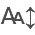

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap
import seaborn as sns
import missingno as msno
from itables import show
from itables import init_notebook_mode
from scipy.stats import pearsonr
import json
import scipy.stats as stats

# Set the maximum number of rows and columns displayed
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 250)

# Set options for itables
init_notebook_mode(all_interactive=True)

%matplotlib inline

To view interactive components from github, click this link:
https://nbviewer.org/github/deannachurch/SBCapstone_CRISPRScreens/blob/main/notebooks/Brunello_count_library.ipynb

# Overview

**Purpose:** Understanding the distributions of crispr guide libraries to determine if we can make a simple app to do power calculations for experimental design. 

**Background:** There are a lot of variabilities in this screens, and lots of false positive. Understanding better ways we can understand effect sizes and the number of samples needed for a statistically significant experiment is useful, even if people can't do the recommended number of samples (for cost or experimental reasons)


# Functions

In [2]:
def define_outliers(df, col):
    """ 
    define_outliers

    Takes a dataframe and a column and calculates the IQR to remove outliers.
    Note- column must be numerical

    Calcualte the Q1, Q3 and IQR and return the outliers for later filtering
    """
    if not pd.api.types.is_numeric_dtype(df[col]):
        raise TypeError(f"The column {col} is not numeric")
    
    Q1=df[col].quantile(0.25)
    Q3=df[col].quantile(0.75)
    IQR = Q3-Q1

    outliers=(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))
    return(outliers)

In [3]:
def box_strip_plot(df, col, title, y_label):
    """ 
    Take a dataframe, the column of interest and some labeling info and make 
    box and stripplots

    return the fig
    """
    outliers=define_outliers(df, col)
    df_outliers = df[outliers]
    df_main = df[~outliers]

    out_melted_df = pd.melt(df_outliers, value_vars=col)
    main_melted_df = pd.melt(df_main, value_vars=col)
    # Create a figure with two subplots (side by side)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6)) 

    # Plot for main data without outliers on the first subplot
    sns.boxplot(x='variable', y='value', data=main_melted_df, color='#9B9B93', boxprops=dict(alpha=0.5), ax=axes[0])
    sns.stripplot(x='variable', y='value', data=main_melted_df, jitter=True, color='#CD8C0F', alpha=0.5, ax=axes[0])
    axes[0].set_title(f"{col}: Main Data without Outliers")
    axes[0].set_xlabel('')  # Turn off x-axis label
    axes[0].set_ylabel(y_label)  # Set y-axis label only for the left plot

    # Plot for outliers on the second subplot
    sns.boxplot(x='variable', y='value', data=out_melted_df, color='#9B9B93', boxprops=dict(alpha=0.5), ax=axes[1])
    sns.stripplot(x='variable', y='value', data=out_melted_df, color='#CD8C0F', jitter=True, ax=axes[1])
    axes[1].set_title(f"{col}: Outliers")
    axes[1].set_xlabel('')  # Turn off x-axis label
    axes[1].set_ylabel('')  # Turn off y-axis label for the right plot

    # Sort df_outliers to find the two biggest values
    top_outliers = df_outliers.sort_values(by=col, ascending=False).head(3)

    #Loop through the top outliers to add labels with 'Target Gene Symbol'
    for index, row in top_outliers.iterrows():
        axes[1].text(x=0+0.1, y=row[col], s=row['Target Gene Symbol'], color='black', va='center')

    # Annotation for the total number of data points in the main data plot
    total_main = len(df_main)
    axes[0].text(0.95, 0.95, f'Total: {total_main}', transform=axes[0].transAxes, 
             horizontalalignment='right', verticalalignment='top', fontsize=12, color='blue')

    # Annotation for the total number of data points in the outliers plot
    total_outliers = len(df_outliers)
    axes[1].text(0.95, 0.95, f'Total: {total_outliers}', transform=axes[1].transAxes, 
             horizontalalignment='right', verticalalignment='top', fontsize=12, color='blue')

    fig.suptitle(f"{col}: {title}")

    return fig

In [4]:
def plot_hist(df, col, bin_no, title, x_label):
    """ 
    Take a dataframe and column of interest, the bin number and plot label info
    and make a histogram of data.

    return the fig.
    """
    # Filter out null values
    non_null_df = guide_df[col].dropna()

    # Plot  histogram
    fig=plt.hist(non_null_df, bins=bin_no, edgecolor='black')

    # Set labels and title
    plt.xlabel(x_label)
    plt.ylabel('Frequency')
    plt.title(title)

    return fig

In [5]:
def cal_cpm(df, col):
    """ 
    cal_cpm: 
    
    take a col in a dataframe that represents a count and calculate the counts per million.
    return the dataframe

    """
    
    if not pd.api.types.is_numeric_dtype(df[col]):
        raise TypeError(f"The column {col} is not numeric")
    total_counts = df[col].sum()
    normalized_col_name = col + '_CPM'  # Create a new column name for the normalized data
    df[normalized_col_name] = (df[col] / total_counts) * 1_000_000

    return df

In [6]:
def dist_plots(df, col_list):
    """ 
    dist_plots 
    take a dataframe and a column list
    Plot the distributions for that columns

    return the figure
    """
    # Calculate the number of rows and columns needed for the subplots
    num_cols = 4  # You can adjust this number based on your preference
    num_rows = len(col_list) // num_cols + (1 if len(col_list) % num_cols > 0 else 0)

    # Create a figure with subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10))
    axs = axs.flatten()  # Flatten the array for easy iteration

    for i, col in enumerate(col_list):
        if not pd.api.types.is_numeric_dtype(df[col]):
            print(f"The column {col} is not numeric, skipping col.")
            continue
        sns.histplot(df[col], kde=True, ax=axs[i])
        axs[i].set_title(f'Distribution of {col}')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    return fig


In [7]:
def dist_plots_by_quartile(df, col_list, quart_list):
    # Calculate the number of rows and columns needed for the subplots
    # Assuming 4 plots per count column (one for each quartile)
    num_cols = 2  # Adjust based on your preference for layout
    num_rows_per_col = 4  # One row per quartile
    total_plots = len(col_list) * num_rows_per_col
    num_rows = total_plots // num_cols + (1 if total_plots % num_cols > 0 else 0)

    # Create a figure with subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))
    axs = axs.flatten()  # Flatten the array for easy iteration

    plot_index = 0  # Index to track the subplot to use
    for idx, col in enumerate(col_list):
        quartile_col=quart_list[idx]

        if quartile_col not in df.columns:
            print(f"No quartile column found for {col}, skipping.")
            continue

        for quartile in sorted(df[quartile_col].unique()):
            sns.histplot(df[df[quartile_col] == quartile][col], kde=True, ax=axs[plot_index])
            axs[plot_index].set_title(f'Distribution of {col} - Quartile {quartile}')
            plot_index += 1

            # Check if we've filled all allocated subplots
            if plot_index >= len(axs):
                break

        # Check if we've filled all allocated subplots
        if plot_index >= len(axs):
            print("Not enough subplots for all quartiles, some plots may be missing.")
            break

    # Hide any unused subplots
    for j in range(plot_index, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    return fig

In [8]:
def q_q_plots(df, dis, col_list, title):
    """ 
    q_q_plots
    take a column, distribution (that is appropriate) and a list of columns to make q-q plots

    return fig
    """
    #Calculate the number of rows and columns needed for the subplots
    num_cols = 4  # You can adjust this number based on your preference
    num_rows = len(col_list) // num_cols + (1 if len(col_list) % num_cols > 0 else 0)

    # Create a figure with subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10))
    axs = axs.flatten()  # Flatten the array for easy iteration
    
    for i, col in enumerate(col_list, 1):
        print(f"Processing {col}")
        if not pd.api.types.is_numeric_dtype(df[col]):
            print(f"The column {col} is not numeric, skipping col.")
            continue
        ax = axs[i]  # Use the current subplot
        stats.probplot(df[col], dist=dis, plot=ax)
        new_title=f"{title}: {col}"
        wrap_title=textwrap.fill(new_title, width = 40)
        ax.set_title(wrap_title)

    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].set_visible(False)
        
    plt.tight_layout()
    return fig

In [142]:
def calculate_quartiles(df, count_cols):
    """
    Calculate quartile columns for each count column.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    count_cols (list): The list of count columns.
    
    Returns:
    pd.DataFrame: The dataframe with added quartile columns.
    """
    for count_col in count_cols:
        quartile_col = f'{count_col}_quartile'
        df[quartile_col] = pd.qcut(df[count_col], 4, labels=False) + 1  # Quartiles 1 to 4
    return df

# Read files

In [9]:
## files to analyze
#from original paper describing this library
#cells used A375 (a melanoma cell line)
brunello='../data/raw/Brunnello_libraryPaper/brunello_plasmid_counts.xlsx' #sheet 1 orig trac, sheet2 mod trac, sheet3 annotations
b_guide_annotation='../data/raw/Brunnello_libraryPaper/broadgpp-brunello-library-contents.txt' #guide annotation from current distributor

#from israeli et al paper, also used Brunello library but in CALU-3 cells
israeli='../data/raw/Israeli_2023/GSE197962_sgRNA_counts.txt'
i_b_guide_annotation='../data/raw/Israeli_2023/broadgpp-brunello-library-contents.txt' #info with this paper

# Check 1: guide list and annotation

Check the two guide files to ensure they contain the same data and annotations

In [10]:
b_guide_df=pd.read_csv(b_guide_annotation, delimiter='\t')
b_guide_df.head()

Target Gene ID Target Gene Symbol Target Transcript Genomic Sequence  \
0             1.0               A1BG       NM_130786.3     NC_000019.10   
1             1.0               A1BG       NM_130786.3     NC_000019.10   
2             1.0               A1BG       NM_130786.3     NC_000019.10   
3             1.0               A1BG       NM_130786.3     NC_000019.10   
4             2.0                A2M       NM_000014.4     NC_000012.12   

   Position of Base After Cut (1-based)     Strand sgRNA Target Sequence  \
0                            58351502.0      sense  CATCTTCTTTCACCTGAACG   
1                            58350637.0  antisense  CTCCGGGGAGAACTCCGGCG   
2                            58351668.0  antisense  TCTCCATGGTGCATCAGCAC   
3                            58351593.0  antisense  TGGAAGTCCACTCCACTCAG   
4                             9090399.0      sense  ACTGCATCTGTGCAAACGGG   

          Target Context Sequence PAM Sequence  Exon Number  Rule Set 2 score  
0  ATCGCATCTTCTTTCACCTGAACGCGGTGG          CGG          5.0            0.6165  
1  CCGGCTCCGGGGAGAACTCCGGCGCGGGCA          CGG          6.0            0.6176  
2  GGACTCTCCATGGTGCATCAGCACAGGCGG          AGG          5.0            0.5264  
3  TAGCTGGAAGTCCACTCCACTCAGGGGAGC          GGG          5.0            0.7156  
4  CCTCACTGCATCTGTGCAAACGGGCGGCAA          CGG         20.0            0.6765

In [11]:
i_guide_df=pd.read_csv(i_b_guide_annotation, delimiter='\t')
i_guide_df.head()

Target Gene ID Target Gene Symbol Target Transcript Genomic Sequence  \
0             1.0               A1BG       NM_130786.3     NC_000019.10   
1             1.0               A1BG       NM_130786.3     NC_000019.10   
2             1.0               A1BG       NM_130786.3     NC_000019.10   
3             1.0               A1BG       NM_130786.3     NC_000019.10   
4             2.0                A2M       NM_000014.4     NC_000012.12   

   Position of Base After Cut (1-based)     Strand sgRNA Target Sequence  \
0                            58351502.0      sense  CATCTTCTTTCACCTGAACG   
1                            58350637.0  antisense  CTCCGGGGAGAACTCCGGCG   
2                            58351668.0  antisense  TCTCCATGGTGCATCAGCAC   
3                            58351593.0  antisense  TGGAAGTCCACTCCACTCAG   
4                             9090399.0      sense  ACTGCATCTGTGCAAACGGG   

          Target Context Sequence PAM Sequence  Exon Number  Rule Set 2 score  
0  ATCGCATCTTCTTTCACCTGAACGCGGTGG          CGG          5.0            0.6165  
1  CCGGCTCCGGGGAGAACTCCGGCGCGGGCA          CGG          6.0            0.6176  
2  GGACTCTCCATGGTGCATCAGCACAGGCGG          AGG          5.0            0.5264  
3  TAGCTGGAAGTCCACTCCACTCAGGGGAGC          GGG          5.0            0.7156  
4  CCTCACTGCATCTGTGCAAACGGGCGGCAA          CGG         20.0            0.6765

In [12]:
## Check the shapes
print(f"The shape of the original file {b_guide_df.shape}")
print(f"The shape of the Israeli guide file {i_guide_df.shape}")

The shape of the original file (77441, 11)
The shape of the Israeli guide file (77441, 11)


In [13]:
diff = b_guide_df.compare(i_guide_df)
print(diff)

Empty DataFrame
Columns: []
Index: []


## conclusion: Guide source

The two guide definitaion data frames seem to be the same. Rename one to 'guide_df' and delete the other dataframe to save space

In [14]:
guide_df=b_guide_df
del i_guide_df
del b_guide_df
show(guide_df.head())

# Info on guide

- [X] How many non-targeting (control) guides
- [X] Distribution of guides per gene
- [X] How many guides are sense/antisense?
- [X] How many different and types of PAMs are targeted?
- [X] How many genes are targeted?
    - [X] Do we need to get transcript length? Will only get this for the one transcript in the file (not many of these have been updated.)
    - [X] Get isoform number [will just use the latest annotation based on gene for this]
    - [X] Add Essential/Non-Essential Annotation
    - [ ] Do we need to get gene length (that is exon + intron length) (holding off for now)
    - [ ] Expression? (may hold off for now as this could get quite complicated)

In [15]:
guide_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77441 entries, 0 to 77440
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Target Gene ID                        76441 non-null  float64
 1   Target Gene Symbol                    77441 non-null  object 
 2   Target Transcript                     76441 non-null  object 
 3   Genomic Sequence                      76441 non-null  object 
 4   Position of Base After Cut (1-based)  76441 non-null  float64
 5   Strand                                76441 non-null  object 
 6   sgRNA Target Sequence                 77441 non-null  object 
 7   Target Context Sequence               76441 non-null  object 
 8   PAM Sequence                          76441 non-null  object 
 9   Exon Number                           76441 non-null  float64
 10  Rule Set 2 score                      76441 non-null  float64
dtypes: float64(4), 

In [16]:
#convert Target Gene ID to int, first have to fillna(0) for non-targeting guides
guide_df['Target Gene ID']=guide_df['Target Gene ID'].fillna(0).astype(int)
guide_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77441 entries, 0 to 77440
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Target Gene ID                        77441 non-null  int64  
 1   Target Gene Symbol                    77441 non-null  object 
 2   Target Transcript                     76441 non-null  object 
 3   Genomic Sequence                      76441 non-null  object 
 4   Position of Base After Cut (1-based)  76441 non-null  float64
 5   Strand                                76441 non-null  object 
 6   sgRNA Target Sequence                 77441 non-null  object 
 7   Target Context Sequence               76441 non-null  object 
 8   PAM Sequence                          76441 non-null  object 
 9   Exon Number                           76441 non-null  float64
 10  Rule Set 2 score                      76441 non-null  float64
dtypes: float64(3), 

In [17]:
# Export transcript list for looking up length in next notebook
tot_tx_list=guide_df['Target Transcript'].to_list()
tx_list=list(set(tot_tx_list))
with open('../data/processed/tx_list.txt', 'w') as file:
    for item in tx_list:
        file.write("%s\n" % item)


In [18]:
print(f"There are {guide_df['Target Gene Symbol'].nunique() -1} genes targeted (subtracted 1 for the 'Non-Targeting Control')")

There are 19114 genes targeted (subtracted 1 for the 'Non-Targeting Control')


In [19]:
gene_counts = guide_df['Target Gene Symbol'].value_counts()
print(gene_counts)

Target Gene Symbol
Non-Targeting Control    1000
WDR26                       4
RUFY1                       4
ORAI2                       4
PAAF1                       4
                         ... 
CT45A1                      2
MTRNR2L1                    2
CT45A2                      2
ZNF502                      2
DEFB107B                    1
Name: count, Length: 19115, dtype: int64


In [20]:
print(f"There are {gene_counts['Non-Targeting Control']} control guides")

There are 1000 control guides


In [21]:
# Filter out 'Non-Targeting Control' from gene_counts
# Calculate the frequency of guide counts
filtered_gene_counts = gene_counts[gene_counts.index != 'Non-Targeting Control']
guide_count_frequency = filtered_gene_counts.value_counts().sort_index()
freq=guide_count_frequency.reset_index(name='Gene Count')
freq.rename(columns={'count': 'Guide Count'}, inplace=True)


In [22]:
show(filtered_gene_counts.head())

In [23]:
gene_id_list=guide_df['Target Gene ID'].fillna(-1).astype(int).to_list()
gid_list=list(set(gene_id_list))
print(len(gid_list))
print(len(set(gid_list)))

19115
19115


In [24]:
print(gid_list)

[0, 1, 2, 100129239, 131076, 9, 10, 12, 13, 14, 15, 16, 729447, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 163882, 43, 131118, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 70, 71, 72, 131149, 81, 100507003, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 163933, 97, 98, 100, 101, 102, 103, 104, 105, 131177, 107, 108, 109, 338692, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 196740, 196743, 140, 141, 142, 143, 146, 147, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 644809, 100129271, 173, 174, 175, 176, 177, 178, 220134, 181, 182, 183, 196792, 185, 186, 187, 189, 190, 191, 644815, 196, 197, 199, 202, 203, 204, 205, 164045, 207, 208, 100507027, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 149840, 229, 230, 231, 238, 239, 240, 241, 242, 246, 247, 248, 249, 250, 251, 164091, 257, 25

In [25]:
with open('../data/processed/gid_list.txt', 'w') as file:
    for item in gid_list:
        file.write("%s\n" % item)

In [26]:
# Summary statistics
summary_stats = filtered_gene_counts.describe()
print("Summary Statistics:\n", summary_stats)

# Detailed statistics
mean_value = filtered_gene_counts.mean()
median_value = filtered_gene_counts.median()
max_value = filtered_gene_counts.max()
min_value = filtered_gene_counts.min()

print("\nDetailed Statistics:")
print("Mean:", mean_value)
print("Median:", median_value)
print("Max:", max_value)
print("Min:", min_value)

Summary Statistics:
 count    19114.000000
mean         3.999215
std          0.041545
min          1.000000
25%          4.000000
50%          4.000000
75%          4.000000
max          4.000000
Name: count, dtype: float64

Detailed Statistics:
Mean: 3.9992152349063512
Median: 4.0
Max: 4
Min: 1


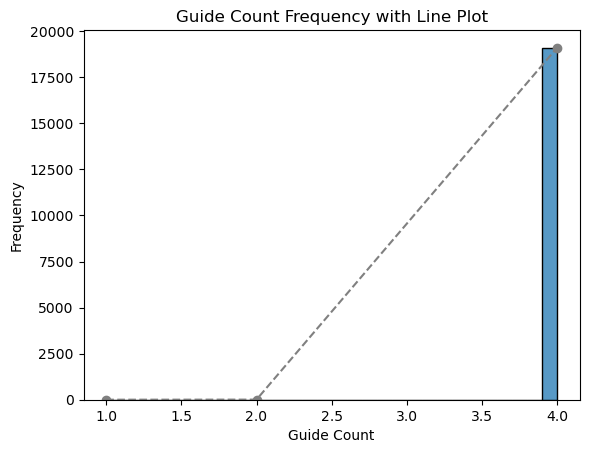

In [27]:
# Plotting the histogram
#Not using function as this one is a bit different
sns.histplot(data=freq, x='Guide Count', weights='Gene Count', bins=30, kde=False)

# Overlaying a line plot
plt.plot(freq['Guide Count'], freq['Gene Count'], marker='o', linestyle='--', color='grey')

# Adding labels and title
plt.xlabel('Guide Count')
plt.ylabel('Frequency')
plt.title('Guide Count Frequency with Line Plot')

# Show plot
plt.show()

# Conclusion: Guide distribution

All but two genes have 4 guides- there is very little count variation in this dataset. 

In [28]:
strand_counts = guide_df['Strand'].value_counts()

In [29]:
show(strand_counts)

In [30]:
strand_counts.plot(kind='bar')
plt.xlabel('Strand')
plt.ylabel('Count')
plt.title('Strand Counts')
plt.show()

# Conclusion: Strand Usage

Fairly even split of sense/antisense strand, with slightly more sense strand guides

In [31]:
pam_counts = guide_df['PAM Sequence'].value_counts()
show(pam_counts)

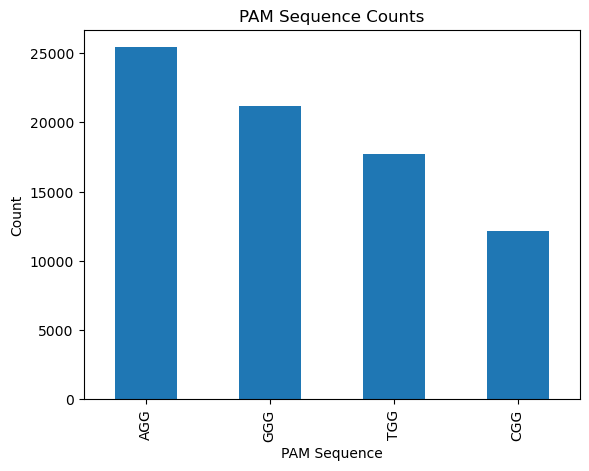

In [32]:
pam_counts.plot(kind='bar')
plt.xlabel('PAM Sequence')
plt.ylabel('Count')
plt.title('PAM Sequence Counts')
plt.show()

# Conclusion: PAM usage

Uneven distribution of PAM site usage.

# Add in gene length information

In [33]:
with open('../data/processed/tx_info.json', 'r') as file:
    tx_dict = json.load(file)

# Convert dictionary to a list of tuples [(key1, value1), (key2, value2), ...]
data = list(tx_dict.items())

# Create a DataFrame from the list of tuples
tx_df = pd.DataFrame(data, columns=['Target Transcript', 'Tx Length'])

# Show the first few rows of the DataFrame
show(tx_df.head())

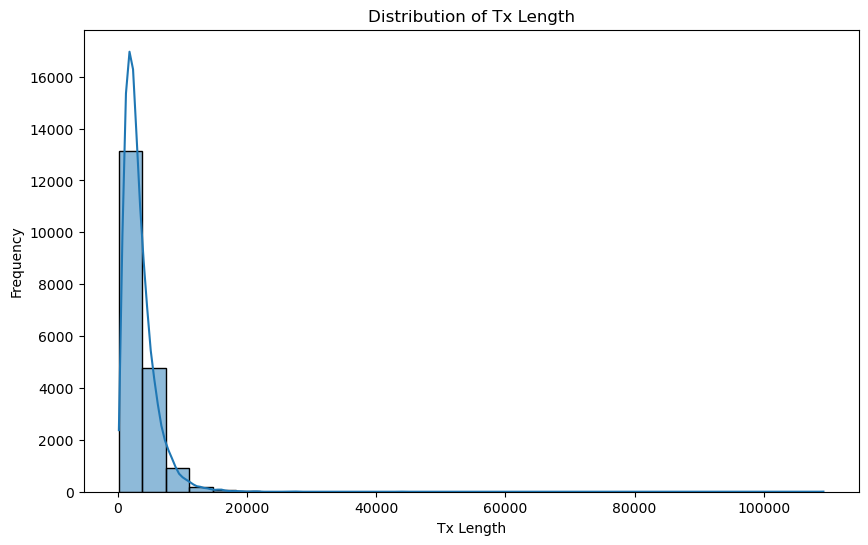

In [34]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.histplot(tx_df['Tx Length'], kde=True, bins=30)  # 'kde=True' adds a Kernel Density Estimate plot
plt.title('Distribution of Tx Length')
plt.xlabel('Tx Length')
plt.ylabel('Frequency')
plt.show()

# Merge length into into the main dataframe

In [35]:
#merge length info into the main dataframe
guide_len_df = guide_df.merge(tx_df, on='Target Transcript', how='left')

print(f"Null values in Tx Length column {guide_len_df['Tx Length'].isnull().sum()}")
#clean old dfs
#del guide_df
#del tx_df
#guide_df=guide_len_df


#show(guide_len_df.head())

Null values in Tx Length column 1000


# Question

The Tx length for non-targeting guides is NaN- which makes sense because they don't target anything. Should I leave as NaN or convert to a dummy number like -1?

In [36]:
#clean old dfs
del guide_df
del tx_df
guide_df=guide_len_df

show(guide_df.head())
del guide_len_df

# Add in isoform number

In [37]:
with open('../data/processed/gene_isoform.json', 'r') as file:
    gene2iso_dict = json.load(file)

# Convert dictionary to a list of tuples [(key1, value1), (key2, value2), ...]
data = list(gene2iso_dict.items())

# Create a DataFrame from the list of tuples
gene2iso_df = pd.DataFrame(data, columns=['Target Gene ID', 'Gene Isoform Count'])

# Show the first few rows of the DataFrame
show(gene2iso_df.head())

In [38]:
gene2iso_df.dtypes

Target Gene ID        object
Gene Isoform Count     int64
dtype: object

In [39]:
gene2iso_df['Target Gene ID']=gene2iso_df['Target Gene ID'].astype(float)

In [40]:
#merge isoform count info into the main dataframe
guide_iso_df = guide_df.merge(gene2iso_df, on='Target Gene ID', how='left')

print(f"Null values in Gene Isoform column {guide_iso_df['Gene Isoform Count'].isnull().sum()}")

Null values in Gene Isoform column 1142


In [41]:
null_iso=guide_iso_df[guide_iso_df['Gene Isoform Count'].isnull()]
show(null_iso)

In [42]:
null_iso_gene=null_iso['Target Gene ID'].to_list()
null_iso_uniq=list(set(null_iso_gene))
print(f"missing isoform counts for {len(null_iso_uniq)}")

missing isoform counts for 37


# Genes with missing isoform counts

There are 1036 of these, a manual review of a few of these suggests these have been withdraw from annotation since the guide library was made. In some cases these were converted to other genes, in others just dropped. Probably OK for now. Will upgrade these to 0, along with non-targeting guides. 

In [43]:
#clean old dfs
del guide_df
del gene2iso_df
guide_df=guide_iso_df

show(guide_df.head())
del guide_iso_df

In [44]:
nan_count = guide_df['Gene Isoform Count'].isnull().sum()
nan_count

1142

In [45]:
guide_df['Gene Isoform Count'] = guide_df['Gene Isoform Count'].fillna(0)

In [46]:
print(guide_df['Gene Isoform Count'].isnull().sum())

0


# Annotate gene essentiality

In [47]:
gene_annot=pd.read_csv('../data/processed/gene_annot.csv')
display(gene_annot)

Target Gene ID    Annotation
0            10189.0     Essential
1             9716.0     Essential
2              372.0     Essential
3            55299.0     Essential
4                NaN     Essential
...              ...           ...
1139        219578.0  NonEssential
1140        148066.0  NonEssential
1141          7783.0  NonEssential
1142         57829.0  NonEssential
1143        151112.0  NonEssential

[1144 rows x 2 columns]

In [48]:
guide_annot_df=guide_df.merge(gene_annot, on='Target Gene ID', how='left')
display(guide_annot_df)

Target Gene ID     Target Gene Symbol Target Transcript  \
0                   1                   A1BG       NM_130786.3   
1                   1                   A1BG       NM_130786.3   
2                   1                   A1BG       NM_130786.3   
3                   1                   A1BG       NM_130786.3   
4                   2                    A2M       NM_000014.4   
...               ...                    ...               ...   
77436               0  Non-Targeting Control               NaN   
77437               0  Non-Targeting Control               NaN   
77438               0  Non-Targeting Control               NaN   
77439               0  Non-Targeting Control               NaN   
77440               0  Non-Targeting Control               NaN   

      Genomic Sequence  Position of Base After Cut (1-based)     Strand  \
0         NC_000019.10                            58351502.0      sense   
1         NC_000019.10                            58350637.0  antisense   
2         NC_000019.10                            58351668.0  antisense   
3         NC_000019.10                            58351593.0  antisense   
4         NC_000012.12                             9090399.0      sense   
...                ...                                   ...        ...   
77436              NaN                                   NaN        NaN   
77437              NaN                                   NaN        NaN   
77438              NaN                                   NaN        NaN   
77439              NaN                                   NaN        NaN   
77440              NaN                                   NaN        NaN   

      sgRNA Target Sequence         Target Context Sequence PAM Sequence  \
0      CATCTTCTTTCACCTGAACG  ATCGCATCTTCTTTCACCTGAACGCGGTGG          CGG   
1      CTCCGGGGAGAACTCCGGCG  CCGGCTCCGGGGAGAACTCCGGCGCGGGCA          CGG   
2      TCTCCATGGTGCATCAGCAC  GGACTCTCCATGGTGCATCAGCACAGGCGG          AGG   
3      TGGAAGTCCACTCCACTCAG  TAGCTGGAAGTCCACTCCACTCAGGGGAGC          GGG   
4      ACTGCATCTGTGCAAACGGG  CCTCACTGCATCTGTGCAAACGGGCGGCAA          CGG   
...                     ...                             ...          ...   
77436  TTTGGTCAACGCATAGCTTG                             NaN          NaN   
77437  TTTTACCTTGTTCACATGGA                             NaN          NaN   
77438  TTTTGACTCTAATCACCGGT                             NaN          NaN   
77439  TTTTTAATACAAGGTAATCT                             NaN          NaN   
77440  TTTTTCTCACCCGATGAATC                             NaN          NaN   

       Exon Number  Rule Set 2 score  Tx Length  Gene Isoform Count Annotation  
0              5.0            0.6165     1766.0                 1.0        NaN  
1              6.0            0.6176     1766.0                 1.0        NaN  
2              5.0            0.5264     1766.0                 1.0        NaN  
3              5.0            0.7156     1766.0                 1.0        NaN  
4             20.0            0.6765     4678.0                 6.0        NaN  
...            ...               ...        ...                 ...        ...  
77436          NaN               NaN        NaN                 0.0        NaN  
77437          NaN               NaN        NaN                 0.0        NaN  
77438          NaN               NaN        NaN                 0.0        NaN  
77439          NaN               NaN        NaN                 0.0        NaN  
77440          NaN               NaN        NaN                 0.0        NaN  

[77441 rows x 14 columns]

In [49]:
guide_annot_df['Annotation'].value_counts()

Annotation
NonEssential    3430
Essential        828
Name: count, dtype: int64

In [50]:
guide_annot_df['Annotation']=guide_annot_df['Annotation'].fillna('Uncategorized')

In [51]:
guide_annot_df['Annotation'].value_counts()

Annotation
Uncategorized    73183
NonEssential      3430
Essential          828
Name: count, dtype: int64

In [52]:
# Clean house
#clean old dfs
del guide_df
del gene_annot
guide_df=guide_annot_df

show(guide_df.head())
del guide_annot_df

In [53]:
guide_df.isnull().count()

Target Gene ID                          77441
Target Gene Symbol                      77441
Target Transcript                       77441
Genomic Sequence                        77441
Position of Base After Cut (1-based)    77441
Strand                                  77441
sgRNA Target Sequence                   77441
Target Context Sequence                 77441
PAM Sequence                            77441
Exon Number                             77441
Rule Set 2 score                        77441
Tx Length                               77441
Gene Isoform Count                      77441
Annotation                              77441
dtype: int64

# Histograms of some guide/tx information

# get genes only

Make a reduced dataframe that drops the guide info and retains the gene info

In [54]:
gene_col=['Target Gene ID', 'Target Gene Symbol','Tx Length', 'Gene Isoform Count']
gene_df=guide_df[gene_col].copy()
print(f"df length before dropping duplicates {len(gene_df.index)}")
gene_df.drop_duplicates(inplace=True)
print(f"df length after dropping duplicates {len(gene_df.index)}")

df length before dropping duplicates 77441
df length after dropping duplicates 19115


In [55]:
gene_df['Target Gene Symbol'].value_counts()

Target Gene Symbol
A1BG                     1
ELL3                     1
C17orf70                 1
WDR26                    1
CXorf21                  1
                        ..
PLCH2                    1
MTFR1                    1
RALGPS1                  1
GCC2                     1
Non-Targeting Control    1
Name: count, Length: 19115, dtype: int64

In [56]:
gene_df = gene_df[gene_df['Target Gene Symbol'] != 'Non-Targeting Control']

In [57]:
show(gene_df)

In [58]:
# Filter out null values
hist_fig=plot_hist(gene_df, 'Tx Length', 10, 'Histogram of Tx Length', 'Tx Length')
plt.show()

# Transcript length

This is hard to look at in a histogram, likely due to Titin throwing things off!

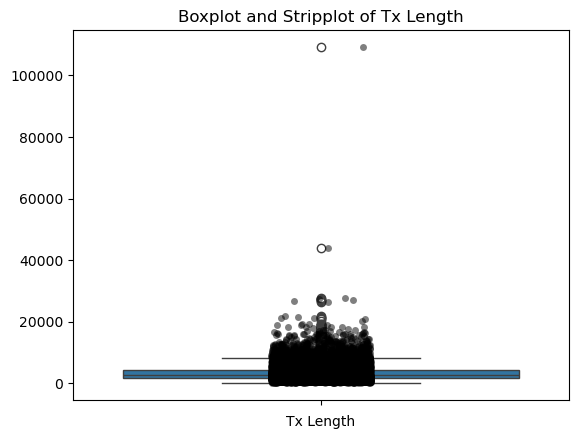

In [59]:
# Create a boxplot
sns.boxplot(data=gene_df, y='Tx Length')

# Create a stripplot
sns.stripplot(data=gene_df, y='Tx Length', color='black', alpha=0.5)

# Set plot title and labels
plt.title('Boxplot and Stripplot of Tx Length')
plt.xlabel('Tx Length')
plt.ylabel('')

# Show the plot
plt.show()

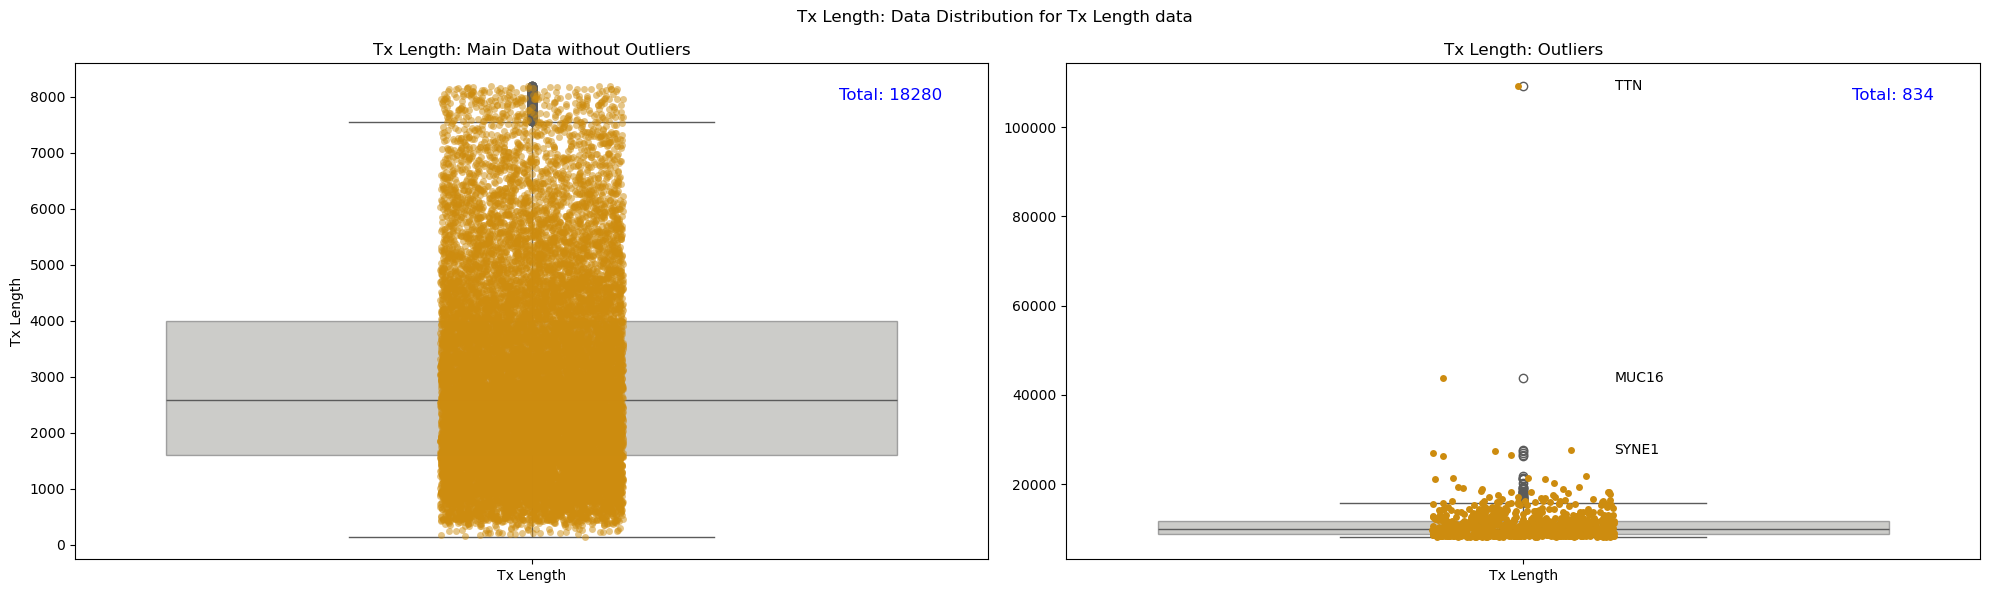

In [60]:
col='Tx Length'
fig = box_strip_plot(gene_df, 'Tx Length', 'Data Distribution for Tx Length data', 'Tx Length')
plt.tight_layout()
plt.show()

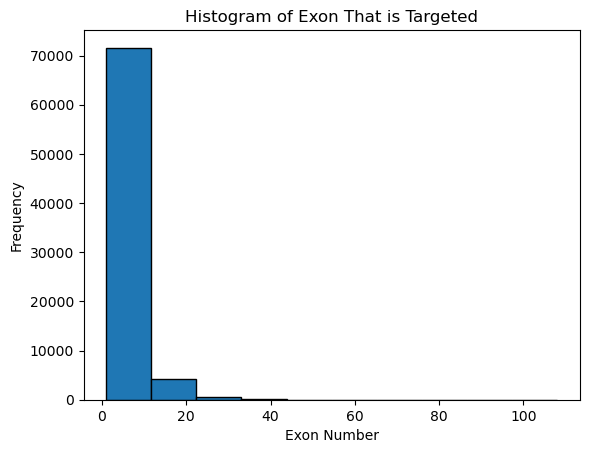

In [61]:
# Exon number
# Note: this is a per guide measuer as it is the exon that is targeted. 
hist_fig=plot_hist(guide_df, 'Exon Number', 10, 'Histogram of Exon That is Targeted', 'Exon Number')
# Display the plot
plt.show()

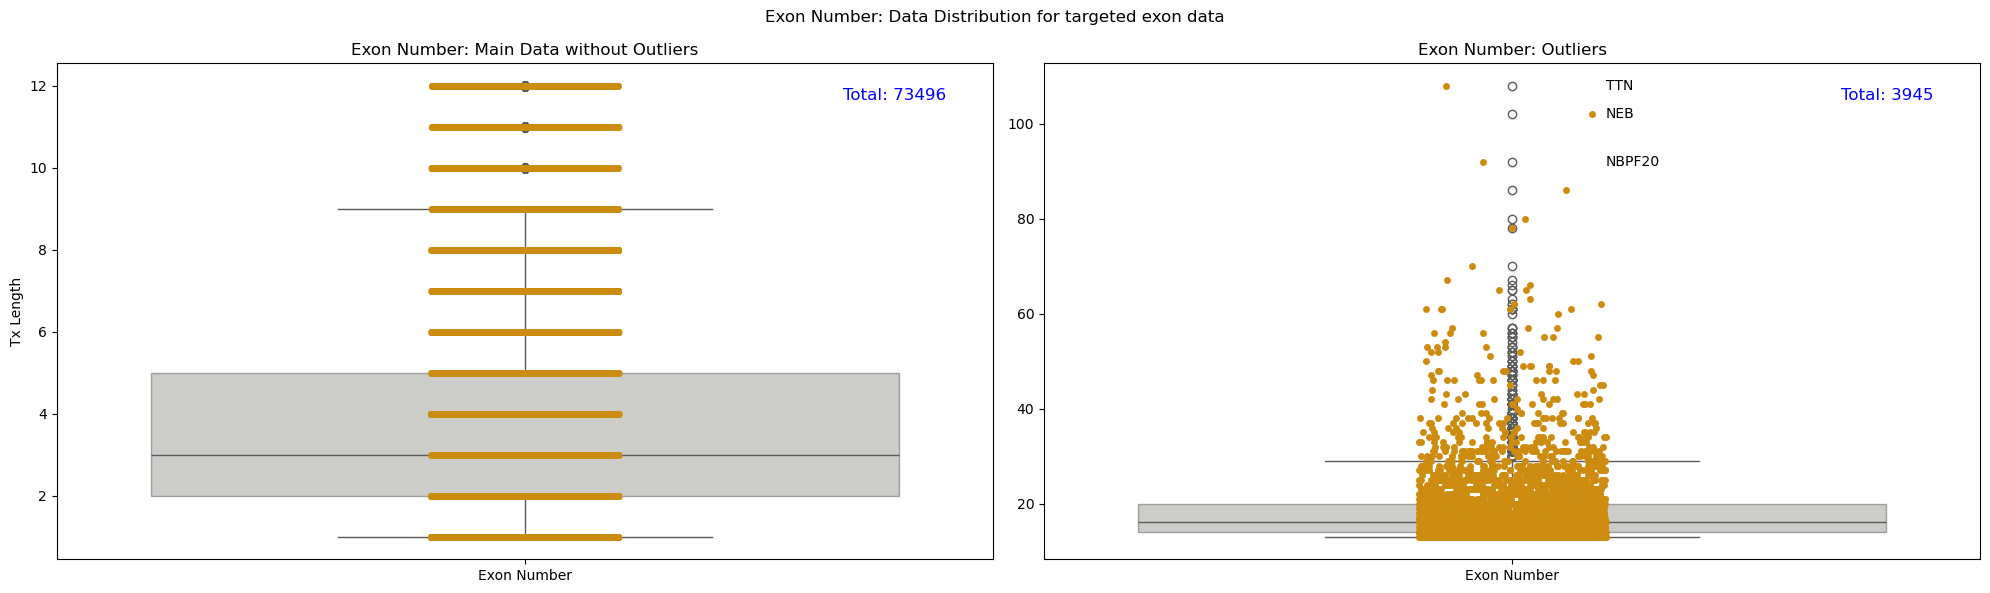

In [62]:
col='Exon Number'
fig = box_strip_plot(guide_df, 'Exon Number', 'Data Distribution for targeted exon data', 'Tx Length')
plt.tight_layout()
plt.show()

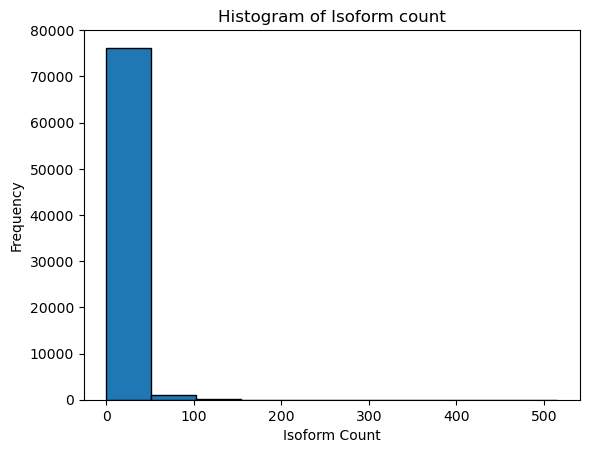

In [63]:
# Isoform number
hist_fig=plot_hist(gene_df, 'Gene Isoform Count', 10, 'Histogram of Isoform count', 'Isoform Count')
# Display the plot
plt.show()

In [64]:
fig=box_strip_plot(gene_df, 'Gene Isoform Count', 'Gene Isoform Counts', 'Isoform Count')
plt.show()

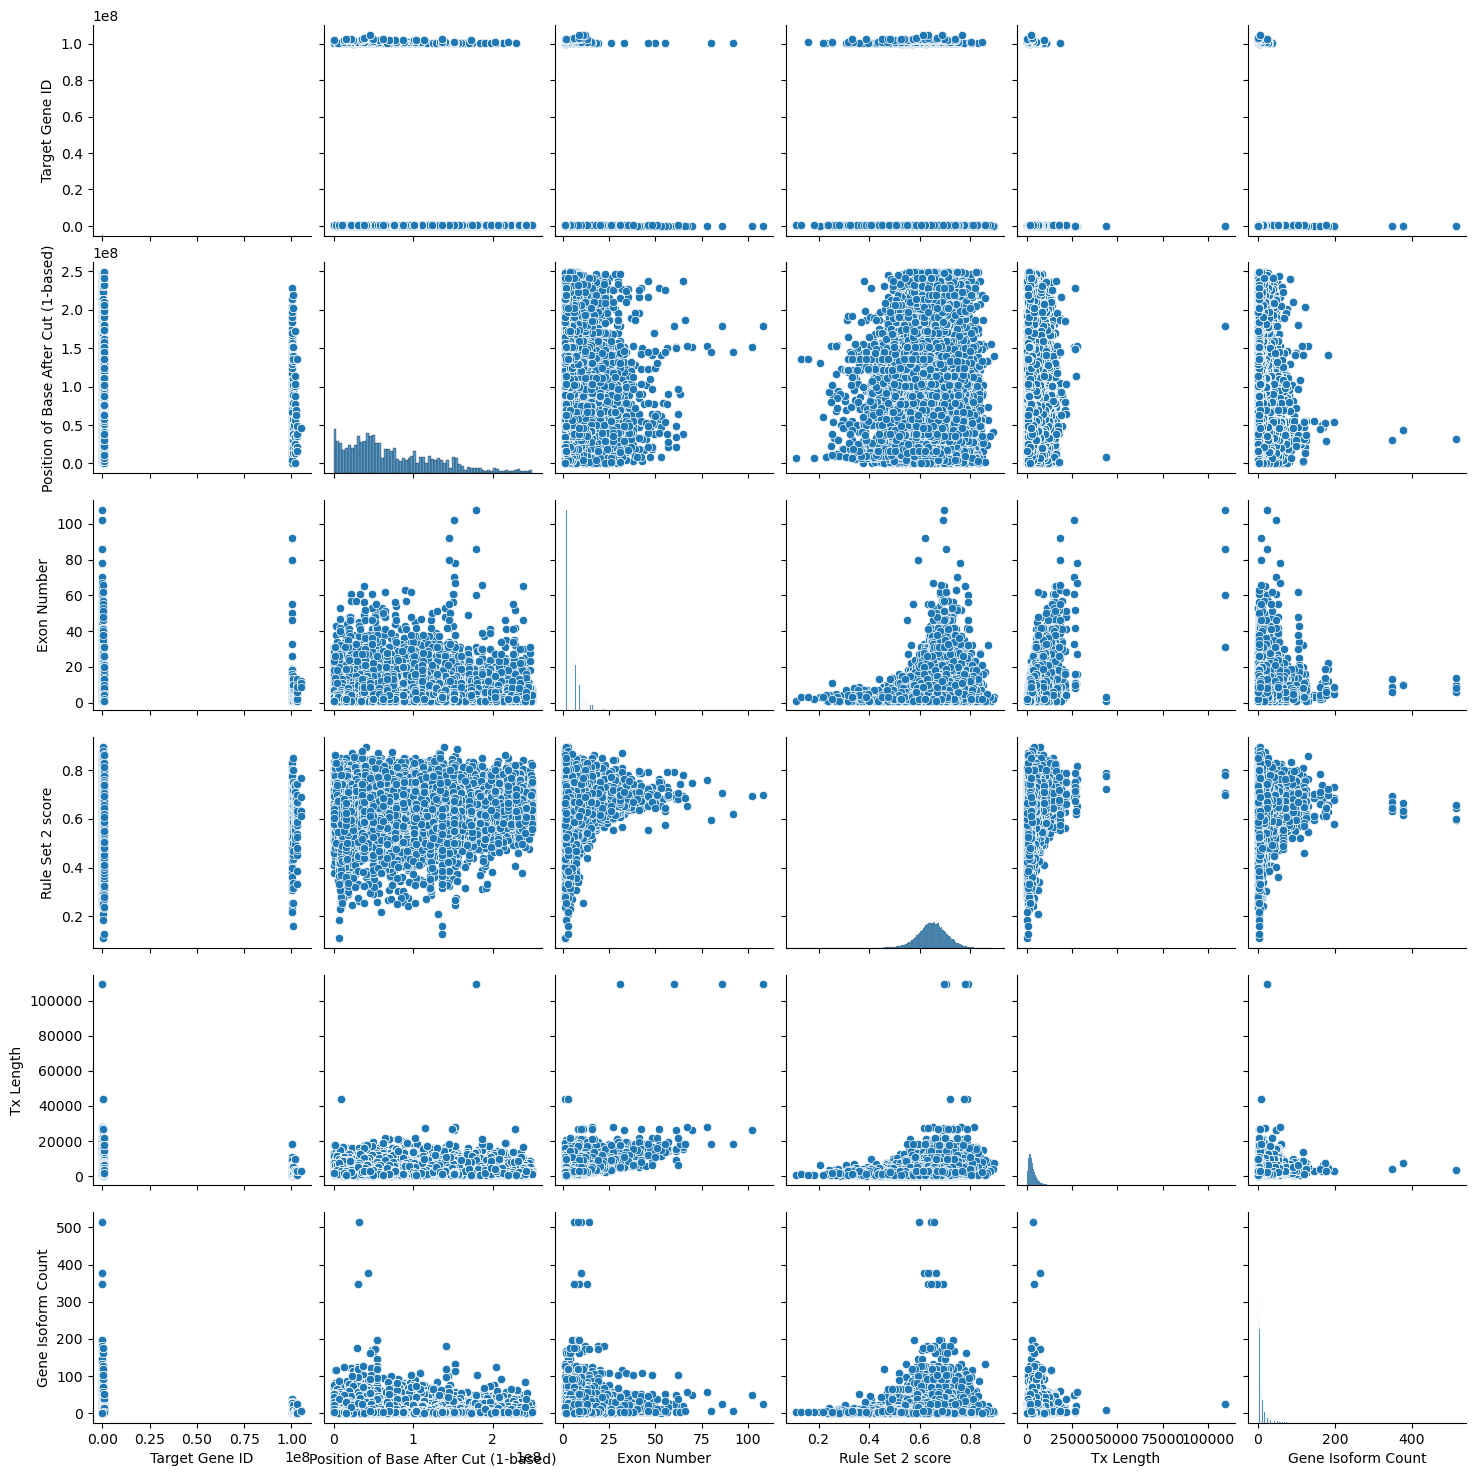

In [78]:
import seaborn as sns

sns.pairplot(guide_df)

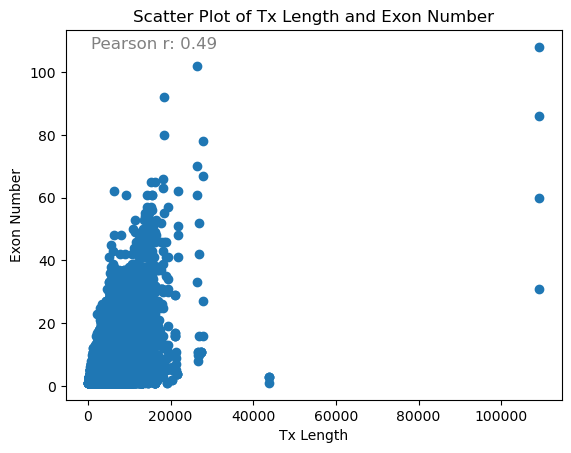

In [69]:
# Remove rows with NaN or inf values
cleaned_guide_df = guide_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['Tx Length', 'Exon Number'])

# Calculate the Pearson correlation coefficient
corr, _ = pearsonr(cleaned_guide_df['Tx Length'], cleaned_guide_df['Exon Number'])
#Create scatter plot
plt.scatter(guide_df['Tx Length'], guide_df['Exon Number'])
plt.xlabel('Tx Length')
plt.ylabel('Exon Number')
plt.title('Scatter Plot of Tx Length and Exon Number')
# Annotate the Pearson correlation coefficient on the plot
plt.annotate(f'Pearson r: {corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color='grey')

plt.show()

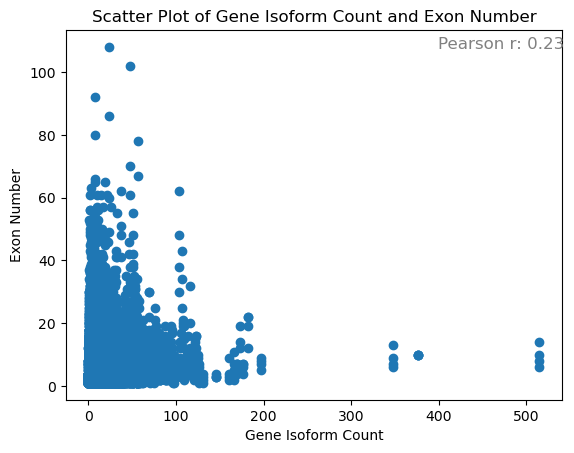

In [75]:
# Remove rows with NaN or inf values
cleaned_guide_df = guide_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['Gene Isoform Count', 'Exon Number'])

# Calculate the Pearson correlation coefficient
corr, _ = pearsonr(cleaned_guide_df['Gene Isoform Count'], cleaned_guide_df['Exon Number'])
plt.scatter(guide_df['Gene Isoform Count'], guide_df['Exon Number'])
plt.xlabel('Gene Isoform Count')
plt.ylabel('Exon Number')
plt.title('Scatter Plot of Gene Isoform Count and Exon Number')
# Annotate the Pearson correlation coefficient on the plot
plt.annotate(f'Pearson r: {corr:.2f}', xy=(0.75, 0.95), xycoords='axes fraction', fontsize=12, color='grey')
plt.show()

# Correlation between gene features

There is a stronger correlation transcript length and exon number (moderate) than between isoform count and exon number (low-moderate). 

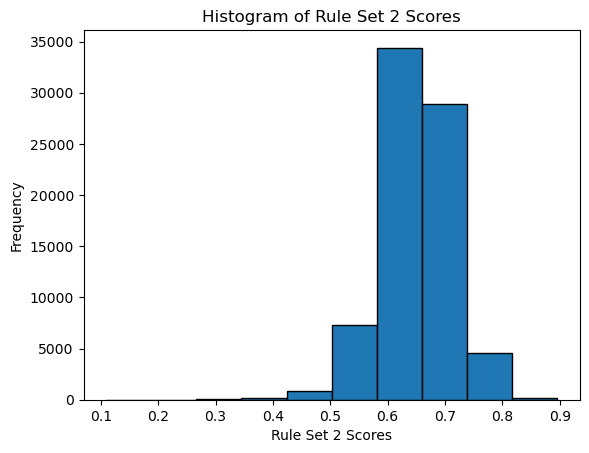

In [76]:
#Rule Set 2 score
#Note- this is a per guide measure- not a per gene measure

hist_fig=plot_hist(guide_df, 'Rule Set 2 score', 10, 'Histogram of Rule Set 2 Scores', 'Rule Set 2 Scores')
plt.show()

# Conclusion: Gene attributes

For many gene level attributes (e.g. isoform number and length) 

* the bulk of the data is in one bin, but there are a large number of outliers in each category.
* while there is certainly class imbalance- there may enough data to look at the impact of these features on guide behaviour- particularly when comparing to the non-targeting guides. 
* there are some correlations between these characteristics, but they are low to moderate. most things seem uncorrelated.

## Guide Counts

Now, let's look at the count data.

- [X] Plot the raw count distributions per sample
- [X] Normalize counts and plot distributions per sample. 

In [79]:
bru1_df=pd.read_excel(brunello, sheet_name=0, header=2)
show(bru1_df.head())

In [80]:
bru1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77441 entries, 0 to 77440
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sgRNA Sequence  77441 non-null  object
 1   pDNA            77441 non-null  int64 
 2   RepA            77441 non-null  int64 
 3   RepB            77441 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 2.4+ MB


In [81]:
bru2_df=pd.read_excel(brunello, sheet_name=1, header=1)
show(bru2_df.head())

In [82]:
bru2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77441 entries, 0 to 77440
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sgRNA Sequence  77441 non-null  object
 1   pDNA            77441 non-null  int64 
 2   RepA            77441 non-null  int64 
 3   RepB            77441 non-null  int64 
 4   RepC            77441 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.0+ MB


In [83]:
# Rename columns so you can put these all in one df
col1_dict={'pDNA': 'trac1_pDNA',
           'RepA': 'trac1_RepA',
           'RepB': 'trac1_RepB'}

col2_dict={'pDNA': 'trac2_pDNA',
           'RepA': 'trac2_RepA',
           'RepB': 'trac2_RepB',
           'RepC': 'trac2_RepC'}
bru1_df.rename(columns=col1_dict, inplace=True)
bru2_df.rename(columns=col2_dict, inplace=True)

show(bru1_df.head())
show(bru2_df.head())

In [84]:
brunello_df = bru1_df.merge(bru2_df, on='sgRNA Sequence')
show(brunello_df.head())

In [85]:
brunello_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77441 entries, 0 to 77440
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sgRNA Sequence  77441 non-null  object
 1   trac1_pDNA      77441 non-null  int64 
 2   trac1_RepA      77441 non-null  int64 
 3   trac1_RepB      77441 non-null  int64 
 4   trac2_pDNA      77441 non-null  int64 
 5   trac2_RepA      77441 non-null  int64 
 6   trac2_RepB      77441 non-null  int64 
 7   trac2_RepC      77441 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 4.7+ MB


In [86]:
brunello_df.describe()

trac1_pDNA    trac1_RepA    trac1_RepB    trac2_pDNA    trac2_RepA  \
count  77441.000000  77441.000000  77441.000000  77441.000000  77441.000000   
mean     389.921385   1004.978732    953.183314    111.247156    815.889361   
std      204.905458    740.151161    699.222670     71.619809    764.315293   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%      230.000000    472.000000    449.000000     60.000000    304.000000   
50%      341.000000    831.000000    792.000000     92.000000    609.000000   
75%      522.000000   1368.000000   1296.000000    145.000000   1090.000000   
max     1395.000000  11468.000000  14672.000000   1005.000000  16451.000000   

         trac2_RepB    trac2_RepC  
count  77441.000000  77441.000000  
mean     895.628453    807.693186  
std      839.403726    773.767215  
min        0.000000      0.000000  
25%      331.000000    279.000000  
50%      669.000000    596.000000  
75%     1205.000000   1099.000000  
max    17113.000000  18192.000000

In [87]:
# clean house
del(bru1_df)
del(bru2_df)

In [88]:
cols=['trac1_pDNA', 'trac1_RepA', 'trac1_RepB', 'trac2_pDNA', 'trac2_RepA', 'trac2_RepB', 'trac2_RepC']
#for col in cols:
#    total_counts = brunello_df[col].sum()
#    normalized_col_name = col + '_CPM'  # Create a new column name for the normalized data
#    brunello_df[normalized_col_name] = (brunello_df[col] / total_counts) * 1_000_000

for col in cols:
    brunello_norm_df=cal_cpm(brunello_df, col)

del brunello_df

show(brunello_norm_df)

In [89]:
brunello_norm_df.describe()

trac1_pDNA    trac1_RepA    trac1_RepB    trac2_pDNA    trac2_RepA  \
count  77441.000000  77441.000000  77441.000000  77441.000000  77441.000000   
mean     389.921385   1004.978732    953.183314    111.247156    815.889361   
std      204.905458    740.151161    699.222670     71.619809    764.315293   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%      230.000000    472.000000    449.000000     60.000000    304.000000   
50%      341.000000    831.000000    792.000000     92.000000    609.000000   
75%      522.000000   1368.000000   1296.000000    145.000000   1090.000000   
max     1395.000000  11468.000000  14672.000000   1005.000000  16451.000000   

         trac2_RepB    trac2_RepC  trac1_pDNA_CPM  trac1_RepA_CPM  \
count  77441.000000  77441.000000    77441.000000    77441.000000   
mean     895.628453    807.693186       12.913056       12.913056   
std      839.403726    773.767215        6.785870        9.510265   
min        0.000000      0.000000        0.000000        0.000000   
25%      331.000000    279.000000        7.616928        6.064768   
50%      669.000000    596.000000       11.292923       10.677589   
75%     1205.000000   1099.000000       17.287114       17.577547   
max    17113.000000  18192.000000       46.198322      147.353298   

       trac1_RepB_CPM  trac2_pDNA_CPM  trac2_RepA_CPM  trac2_RepB_CPM  \
count    77441.000000    77441.000000    77441.000000    77441.000000   
mean        12.913056       12.913056       12.913056       12.913056   
std          9.472576        8.313297       12.096795       12.102415   
min          0.000000        0.000000        0.000000        0.000000   
25%          6.082736        6.964523        4.811399        4.772316   
50%         10.729458       10.678935        9.638625        9.645556   
75%         17.557295       16.830931       17.251397       17.373536   
max        198.765925      116.655761      260.369483      246.733044   

       trac2_RepC_CPM  
count    77441.000000  
mean        12.913056  
std         12.370662  
min          0.000000  
25%          4.460534  
50%          9.528595  
75%         17.570346  
max        290.845987

In [90]:
brunello_norm_df.isnull().sum()

sgRNA Sequence    0
trac1_pDNA        0
trac1_RepA        0
trac1_RepB        0
trac2_pDNA        0
trac2_RepA        0
trac2_RepB        0
trac2_RepC        0
trac1_pDNA_CPM    0
trac1_RepA_CPM    0
trac1_RepB_CPM    0
trac2_pDNA_CPM    0
trac2_RepA_CPM    0
trac2_RepB_CPM    0
trac2_RepC_CPM    0
dtype: int64

In [91]:
brunello_norm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77441 entries, 0 to 77440
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sgRNA Sequence  77441 non-null  object 
 1   trac1_pDNA      77441 non-null  int64  
 2   trac1_RepA      77441 non-null  int64  
 3   trac1_RepB      77441 non-null  int64  
 4   trac2_pDNA      77441 non-null  int64  
 5   trac2_RepA      77441 non-null  int64  
 6   trac2_RepB      77441 non-null  int64  
 7   trac2_RepC      77441 non-null  int64  
 8   trac1_pDNA_CPM  77441 non-null  float64
 9   trac1_RepA_CPM  77441 non-null  float64
 10  trac1_RepB_CPM  77441 non-null  float64
 11  trac2_pDNA_CPM  77441 non-null  float64
 12  trac2_RepA_CPM  77441 non-null  float64
 13  trac2_RepB_CPM  77441 non-null  float64
 14  trac2_RepC_CPM  77441 non-null  float64
dtypes: float64(7), int64(7), object(1)
memory usage: 8.9+ MB


In [92]:
brunello_norm_gene_df=brunello_norm_df.merge(guide_df, left_on='sgRNA Sequence', right_on='sgRNA Target Sequence', how="left")
show(brunello_norm_gene_df.head())

In [93]:
brunello_norm_gene_df[brunello_norm_gene_df['Target Gene ID']==29957]

sgRNA Sequence  trac1_pDNA  trac1_RepA  trac1_RepB  trac2_pDNA  \
0      AAAAAAAATCCGGACAATGG         522         729         774         247   
27139  CCAGGCACTGGACCGCAATG         663        1869        1789         174   
29333  CCGTCTGAAAATCATGATGC         640        1116        1203         136   
54696  GGTATCCGCTCGCTTTGGAG         635         837         537         200   

       trac2_RepA  trac2_RepB  trac2_RepC  trac1_pDNA_CPM  trac1_RepA_CPM  \
0             358        1146         623       17.287114        9.366982   
27139        2818        2942        2796       21.956622       24.014938   
29333         623         711         545       21.194929       14.339578   
54696         649         695         317       21.029344       10.754684   

       trac1_RepB_CPM  trac2_pDNA_CPM  trac2_RepA_CPM  trac2_RepB_CPM  \
0           10.485607       28.670620        5.666055       16.522881   
27139       24.236112       20.197117       44.600401       42.417379   
29333       16.297397       15.786252        9.860202       10.251107   
54696        7.274898       23.215077       10.271703       10.020421   

       trac2_RepC_CPM  Target Gene ID Target Gene Symbol Target Transcript  \
0            9.960260           29957           SLC25A24       NM_013386.4   
27139       44.701263           29957           SLC25A24       NM_013386.4   
29333        8.713229           29957           SLC25A24       NM_013386.4   
54696        5.068062           29957           SLC25A24       NM_013386.4   

      Genomic Sequence  Position of Base After Cut (1-based) Strand  \
0         NC_000001.11                           108157552.0  sense   
27139     NC_000001.11                           108200039.0  sense   
29333     NC_000001.11                           108157467.0  sense   
54696     NC_000001.11                           108155053.0  sense   

      sgRNA Target Sequence         Target Context Sequence PAM Sequence  \
0      AAAAAAAATCCGGACAATGG  GACGAAAAAAAATCCGGACAATGGTGGAGG          TGG   
27139  CCAGGCACTGGACCGCAATG  TCTTCCAGGCACTGGACCGCAATGGGGACG          GGG   
29333  CCGTCTGAAAATCATGATGC  TGGACCGTCTGAAAATCATGATGCAGGTGA          AGG   
54696  GGTATCCGCTCGCTTTGGAG  AGGAGGTATCCGCTCGCTTTGGAGGGGAAA          GGG   

       Exon Number  Rule Set 2 score  Tx Length  Gene Isoform Count  \
0              5.0            0.6034     3600.0                 5.0   
27139          1.0            0.6626     3600.0                 5.0   
29333          5.0            0.5933     3600.0                 5.0   
54696          6.0            0.6107     3600.0                 5.0   

          Annotation  
0      Uncategorized  
27139  Uncategorized  
29333  Uncategorized  
54696  Uncategorized

In [94]:
brunello_norm_gene_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77441 entries, 0 to 77440
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   sgRNA Sequence                        77441 non-null  object 
 1   trac1_pDNA                            77441 non-null  int64  
 2   trac1_RepA                            77441 non-null  int64  
 3   trac1_RepB                            77441 non-null  int64  
 4   trac2_pDNA                            77441 non-null  int64  
 5   trac2_RepA                            77441 non-null  int64  
 6   trac2_RepB                            77441 non-null  int64  
 7   trac2_RepC                            77441 non-null  int64  
 8   trac1_pDNA_CPM                        77441 non-null  float64
 9   trac1_RepA_CPM                        77441 non-null  float64
 10  trac1_RepB_CPM                        77441 non-null  float64
 11  trac2_pDNA_CPM 

In [95]:
foo=brunello_norm_gene_df[brunello_norm_gene_df['Target Gene Symbol'].isnull()]
print(len(foo.index))

0


In [96]:
#Clean house
brunello_norm_df=brunello_norm_gene_df
del brunello_norm_gene_df
show(brunello_norm_df.head())

In [97]:
brunello_norm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77441 entries, 0 to 77440
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   sgRNA Sequence                        77441 non-null  object 
 1   trac1_pDNA                            77441 non-null  int64  
 2   trac1_RepA                            77441 non-null  int64  
 3   trac1_RepB                            77441 non-null  int64  
 4   trac2_pDNA                            77441 non-null  int64  
 5   trac2_RepA                            77441 non-null  int64  
 6   trac2_RepB                            77441 non-null  int64  
 7   trac2_RepC                            77441 non-null  int64  
 8   trac1_pDNA_CPM                        77441 non-null  float64
 9   trac1_RepA_CPM                        77441 non-null  float64
 10  trac1_RepB_CPM                        77441 non-null  float64
 11  trac2_pDNA_CPM 

In [98]:
dist_plots(brunello_norm_df, cols)

plt.tight_layout()
plt.show()

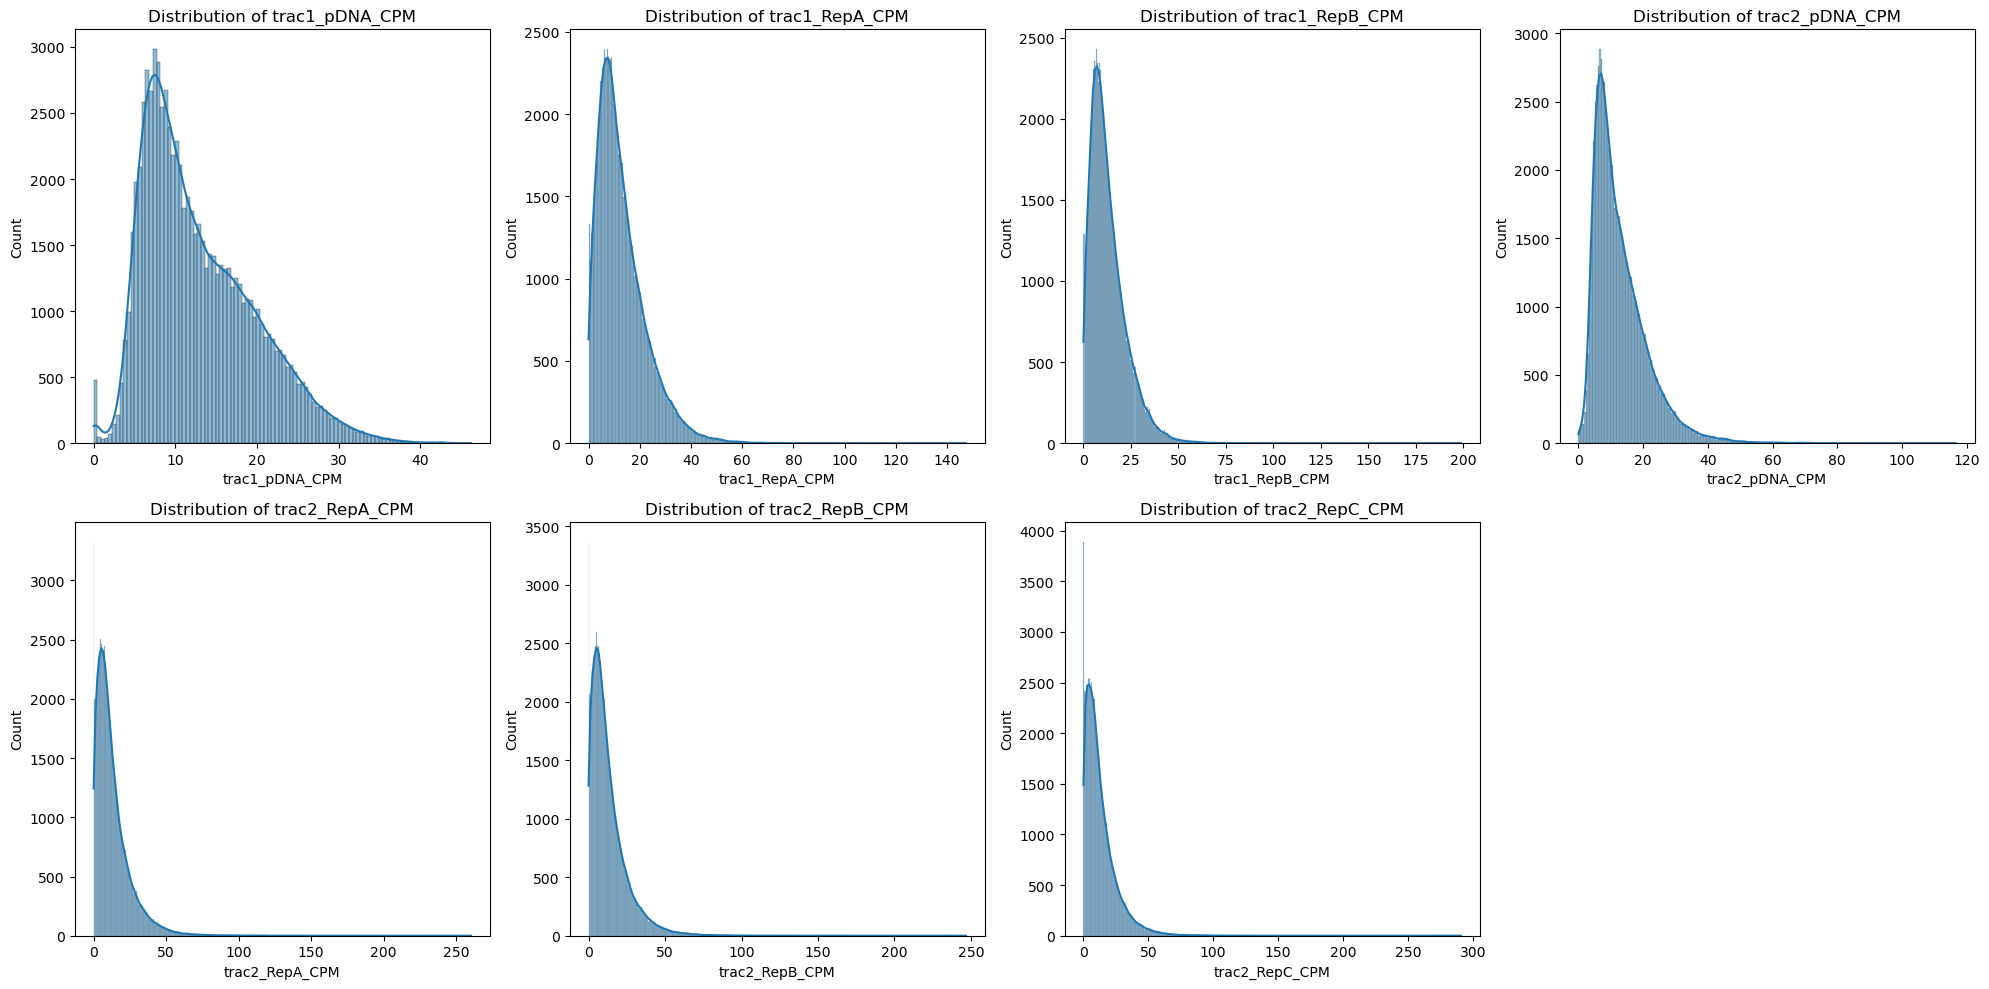

In [99]:
norm_cols=[col + '_CPM' for col in cols]
dist_plots(brunello_norm_df, norm_cols)
plt.tight_layout()
plt.show()

# Distributions

The distribution of the raw and the normalized counts look pretty similar. 

In [100]:
q_q_plots(brunello_norm_df, "norm", norm_cols, "Comparison of data to normal distribution")
plt.tight_layout()
plt.show()

Processing trac1_pDNA_CPM
Processing trac1_RepA_CPM
Processing trac1_RepB_CPM
Processing trac2_pDNA_CPM
Processing trac2_RepA_CPM
Processing trac2_RepB_CPM
Processing trac2_RepC_CPM


Processing trac1_pDNA_CPM
Processing trac1_RepA_CPM
Processing trac1_RepB_CPM
Processing trac2_pDNA_CPM
Processing trac2_RepA_CPM
Processing trac2_RepB_CPM
Processing trac2_RepC_CPM


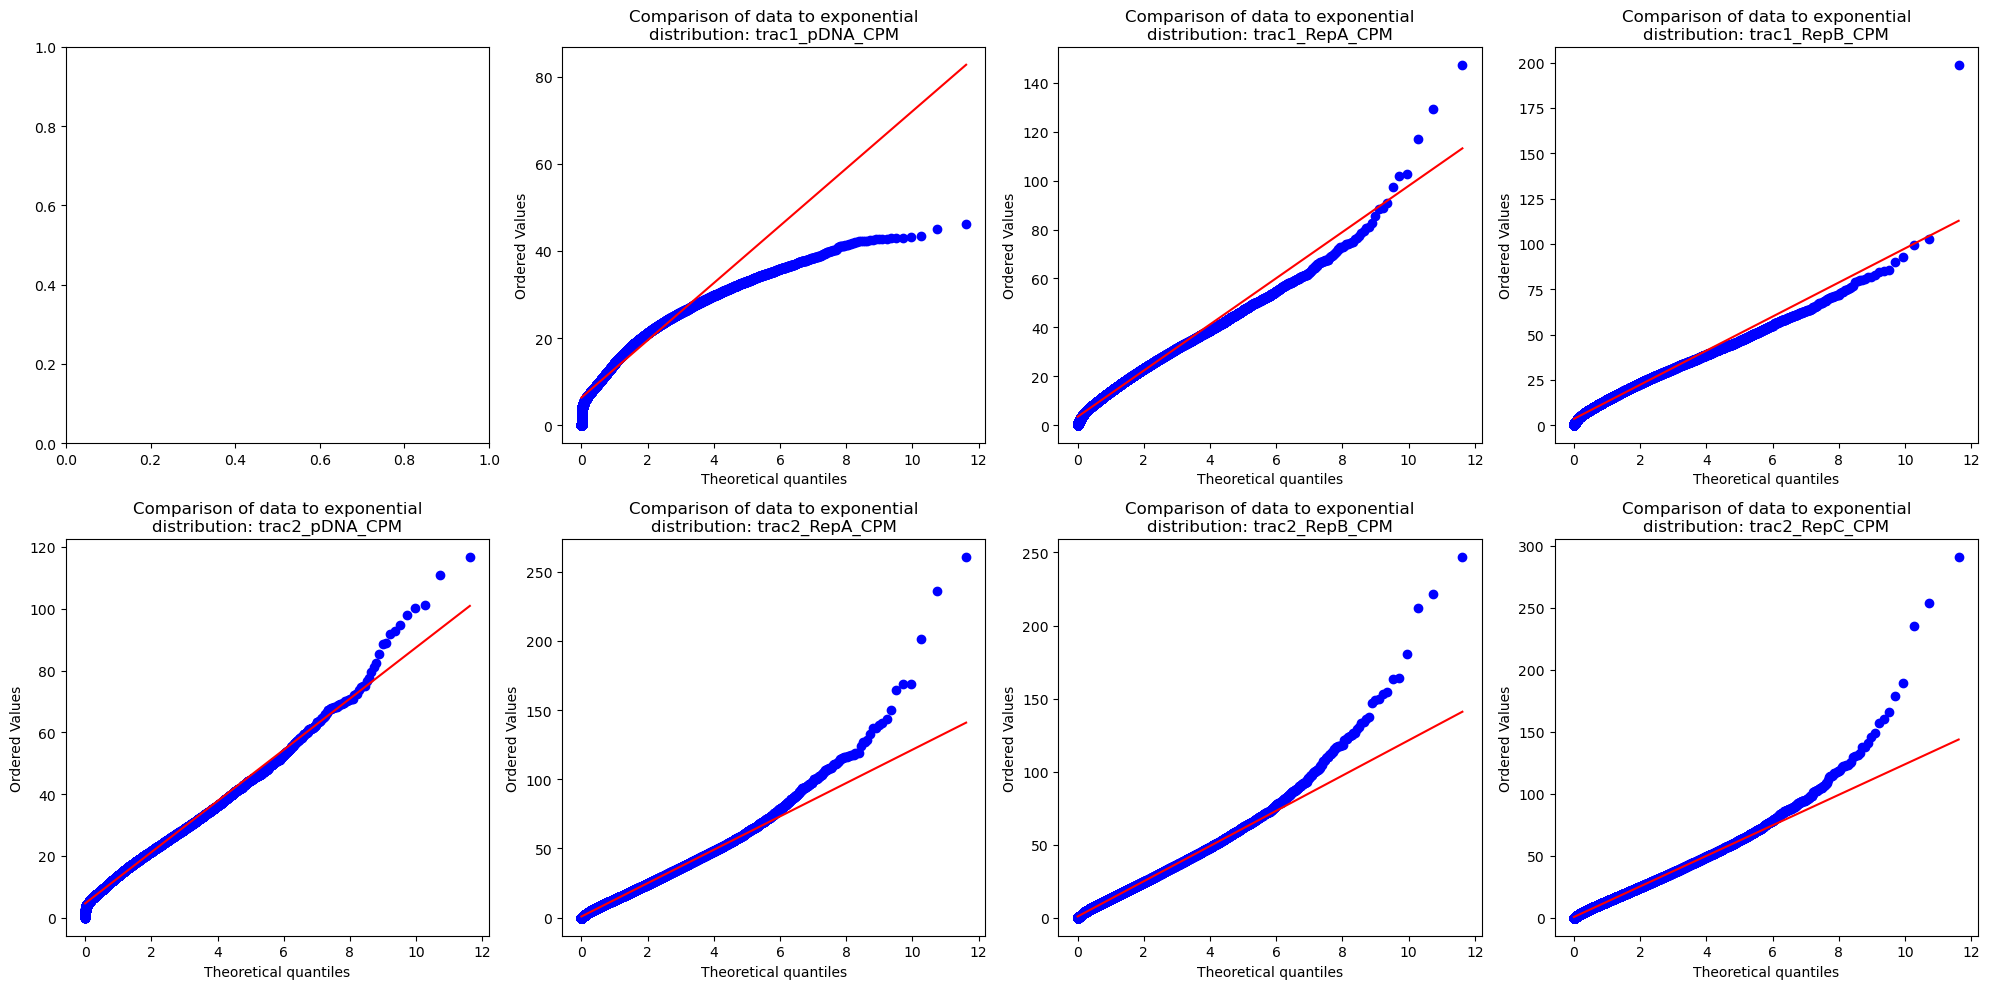

In [101]:
q_q_plots(brunello_norm_df, "expon", norm_cols, "Comparison of data to exponential distribution")
plt.tight_layout()
plt.show()

In [107]:
print(brunello_norm_df.columns)

Index(['sgRNA Sequence', 'trac1_pDNA', 'trac1_RepA', 'trac1_RepB',
       'trac2_pDNA', 'trac2_RepA', 'trac2_RepB', 'trac2_RepC',
       'trac1_pDNA_CPM', 'trac1_RepA_CPM', 'trac1_RepB_CPM', 'trac2_pDNA_CPM',
       'trac2_RepA_CPM', 'trac2_RepB_CPM', 'trac2_RepC_CPM', 'Target Gene ID',
       'Target Gene Symbol', 'Target Transcript', 'Genomic Sequence',
       'Position of Base After Cut (1-based)', 'Strand',
       'sgRNA Target Sequence', 'Target Context Sequence', 'PAM Sequence',
       'Exon Number', 'Rule Set 2 score', 'Tx Length', 'Gene Isoform Count',
       'Annotation'],
      dtype='object')


In [112]:
columns_to_keep = ['Target Gene Symbol'] + [col for col in brunello_norm_df.columns if col.startswith('trac')]
brunello_red_df = brunello_norm_df[columns_to_keep]
show(brunello_red_df.head())

In [113]:
combined_df = brunello_red_df.groupby('Target Gene Symbol').sum().reset_index()

In [114]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19115 entries, 0 to 19114
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Target Gene Symbol  19115 non-null  object 
 1   trac1_pDNA          19115 non-null  int64  
 2   trac1_RepA          19115 non-null  int64  
 3   trac1_RepB          19115 non-null  int64  
 4   trac2_pDNA          19115 non-null  int64  
 5   trac2_RepA          19115 non-null  int64  
 6   trac2_RepB          19115 non-null  int64  
 7   trac2_RepC          19115 non-null  int64  
 8   trac1_pDNA_CPM      19115 non-null  float64
 9   trac1_RepA_CPM      19115 non-null  float64
 10  trac1_RepB_CPM      19115 non-null  float64
 11  trac2_pDNA_CPM      19115 non-null  float64
 12  trac2_RepA_CPM      19115 non-null  float64
 13  trac2_RepB_CPM      19115 non-null  float64
 14  trac2_RepC_CPM      19115 non-null  float64
dtypes: float64(7), int64(7), object(1)
memory usage: 2.2+

In [115]:
show(combined_df.head())

In [116]:
##Double check that counts are right- they seem to be
brunello_norm_df[brunello_norm_df['Target Gene Symbol']=='A1BG']

sgRNA Sequence  trac1_pDNA  trac1_RepA  trac1_RepB  trac2_pDNA  \
25134  CATCTTCTTTCACCTGAACG         563        1670        1411         327   
34352  CTCCGGGGAGAACTCCGGCG         472        1144         774         120   
66223  TCTCCATGGTGCATCAGCAC           2           0           0           4   
70595  TGGAAGTCCACTCCACTCAG         674        1566        1678         165   

       trac2_RepA  trac2_RepB  trac2_RepC  trac1_pDNA_CPM  trac1_RepA_CPM  \
25134        1351        2055        1533       18.644914       21.457971   
34352        1196         982        1472       15.631260       14.699352   
66223           3           0           0        0.066234        0.000000   
70595        2287        2978        1812       22.320910       20.121666   

       trac1_RepB_CPM  trac2_pDNA_CPM  trac2_RepA_CPM  trac2_RepB_CPM  \
25134       19.115235       37.956651       21.382236       29.628727   
34352       10.485607       13.929046       18.929056       14.158350   
66223        0.000000        0.464302        0.047481        0.000000   
70595       22.732363       19.152438       36.196280       42.936423   

       trac2_RepC_CPM  Target Gene ID Target Gene Symbol Target Transcript  \
25134       24.508954               1               A1BG       NM_130786.3   
34352       23.533712               1               A1BG       NM_130786.3   
66223        0.000000               1               A1BG       NM_130786.3   
70595       28.969488               1               A1BG       NM_130786.3   

      Genomic Sequence  Position of Base After Cut (1-based)     Strand  \
25134     NC_000019.10                            58351502.0      sense   
34352     NC_000019.10                            58350637.0  antisense   
66223     NC_000019.10                            58351668.0  antisense   
70595     NC_000019.10                            58351593.0  antisense   

      sgRNA Target Sequence         Target Context Sequence PAM Sequence  \
25134  CATCTTCTTTCACCTGAACG  ATCGCATCTTCTTTCACCTGAACGCGGTGG          CGG   
34352  CTCCGGGGAGAACTCCGGCG  CCGGCTCCGGGGAGAACTCCGGCGCGGGCA          CGG   
66223  TCTCCATGGTGCATCAGCAC  GGACTCTCCATGGTGCATCAGCACAGGCGG          AGG   
70595  TGGAAGTCCACTCCACTCAG  TAGCTGGAAGTCCACTCCACTCAGGGGAGC          GGG   

       Exon Number  Rule Set 2 score  Tx Length  Gene Isoform Count  \
25134          5.0            0.6165     1766.0                 1.0   
34352          6.0            0.6176     1766.0                 1.0   
66223          5.0            0.5264     1766.0                 1.0   
70595          5.0            0.7156     1766.0                 1.0   

          Annotation  
25134  Uncategorized  
34352  Uncategorized  
66223  Uncategorized  
70595  Uncategorized

In [117]:
#Now do dist plots by gene

dist_plots(combined_df, cols)

plt.tight_layout()
plt.show()

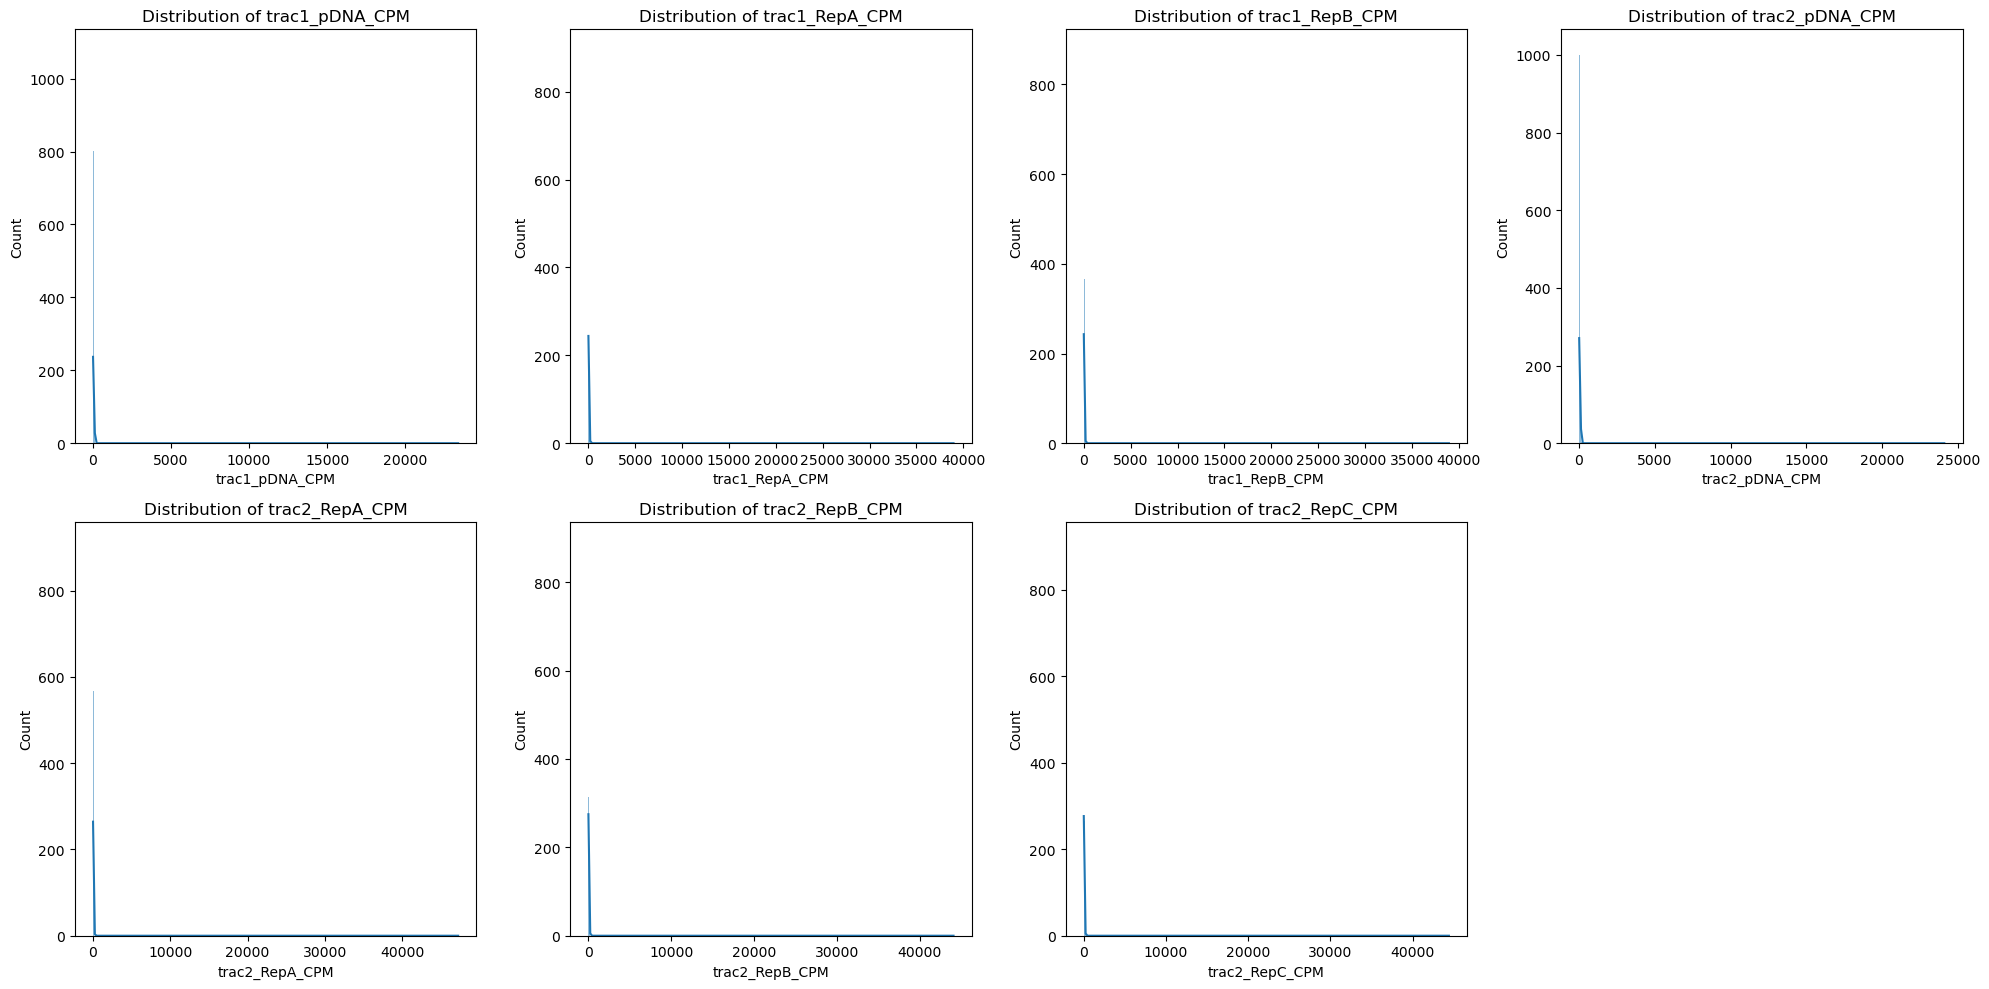

In [118]:
dist_plots(combined_df, norm_cols)
plt.tight_layout()
plt.show()

In [119]:
q_q_plots(combined_df, "norm", norm_cols, "Comparison of brunello gene count data to normal distribution")
plt.tight_layout()
plt.show()

Processing trac1_pDNA_CPM
Processing trac1_RepA_CPM
Processing trac1_RepB_CPM
Processing trac2_pDNA_CPM
Processing trac2_RepA_CPM
Processing trac2_RepB_CPM
Processing trac2_RepC_CPM


In [120]:
q_q_plots(combined_df, "expon", norm_cols, "Comparison of brunello gene data to exponential distribution")
plt.tight_layout()
plt.show()

Processing trac1_pDNA_CPM
Processing trac1_RepA_CPM
Processing trac1_RepB_CPM
Processing trac2_pDNA_CPM
Processing trac2_RepA_CPM
Processing trac2_RepB_CPM
Processing trac2_RepC_CPM


# Distribution at the gene level

This looks much different. And maybe matches the normal distribution better (based on the Q-Q plots). But is this less informative?

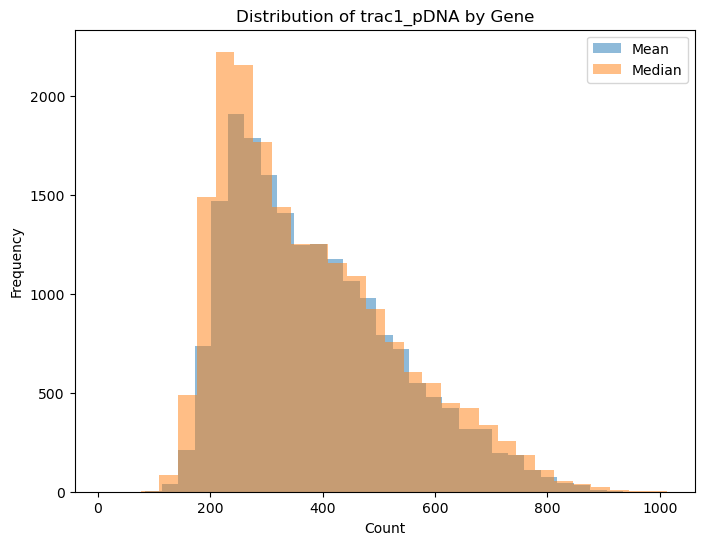

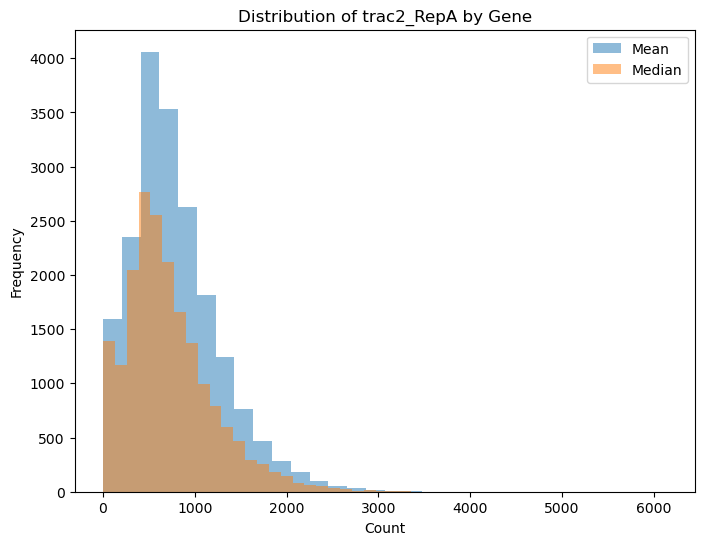

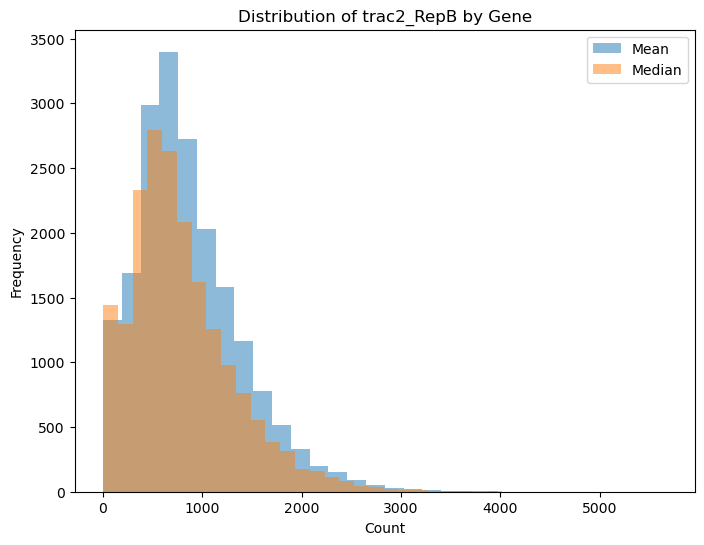

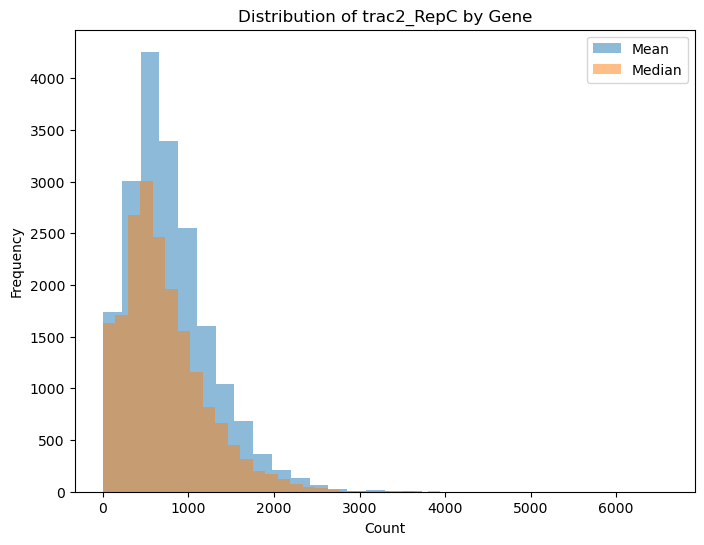

In [121]:
# Calculate mean and median for each count by gene
mean_values = brunello_norm_df.groupby('Target Gene Symbol')[cols].mean()
median_values = brunello_norm_df.groupby('Target Gene Symbol')[cols].median()

show(mean_values.head())
show(median_values.head())
# Plot the distributions
for col in cols:
    plt.figure(figsize=(8, 6))
    plt.hist(mean_values[col], bins=30, alpha=0.5, label='Mean')
    plt.hist(median_values[col], bins=30, alpha=0.5, label='Median')
    plt.xlabel('Count')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {col} by Gene')
    plt.legend()
    plt.show()

Processing trac1_pDNA
Processing trac1_RepA
Processing trac1_RepB
Processing trac2_pDNA
Processing trac2_RepA
Processing trac2_RepB
Processing trac2_RepC


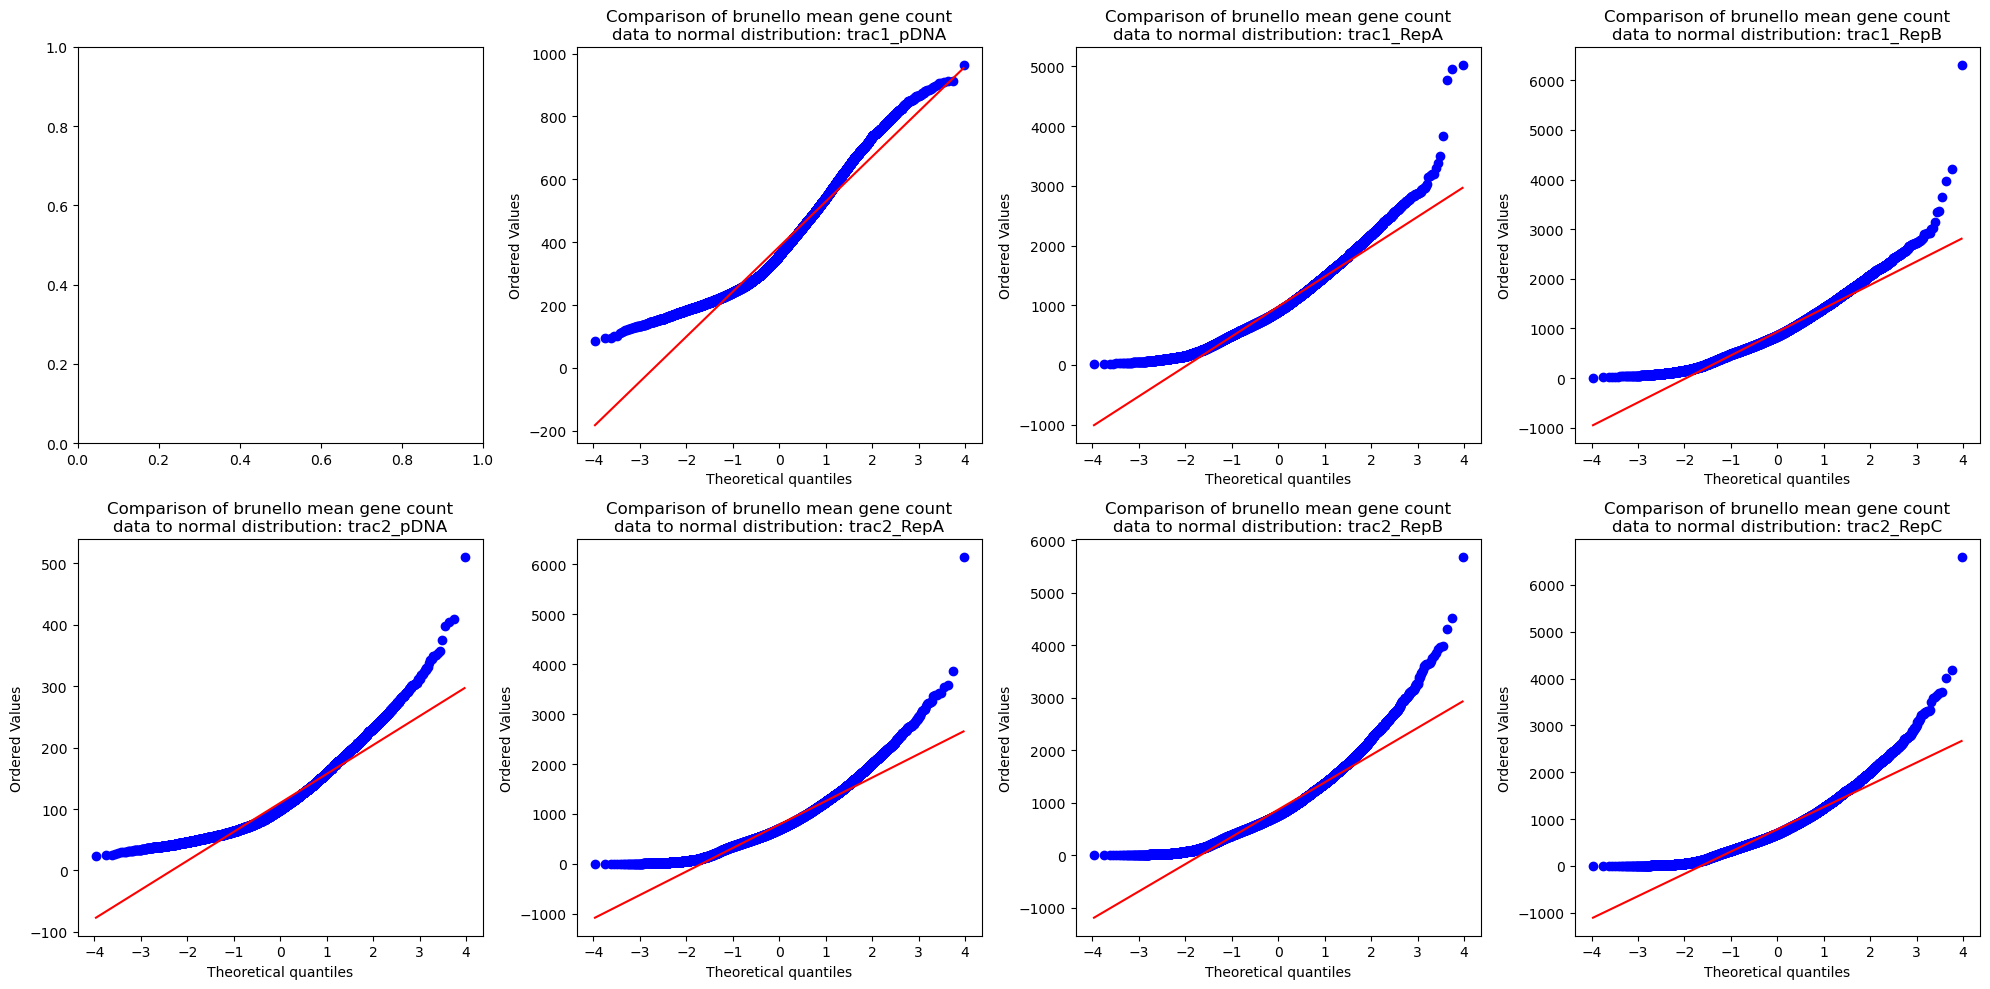

In [122]:
q_q_plots(mean_values, "norm", cols, "Comparison of brunello mean gene count data to normal distribution")
plt.tight_layout()
plt.show()

Processing trac1_pDNA
Processing trac1_RepA
Processing trac1_RepB
Processing trac2_pDNA
Processing trac2_RepA
Processing trac2_RepB
Processing trac2_RepC


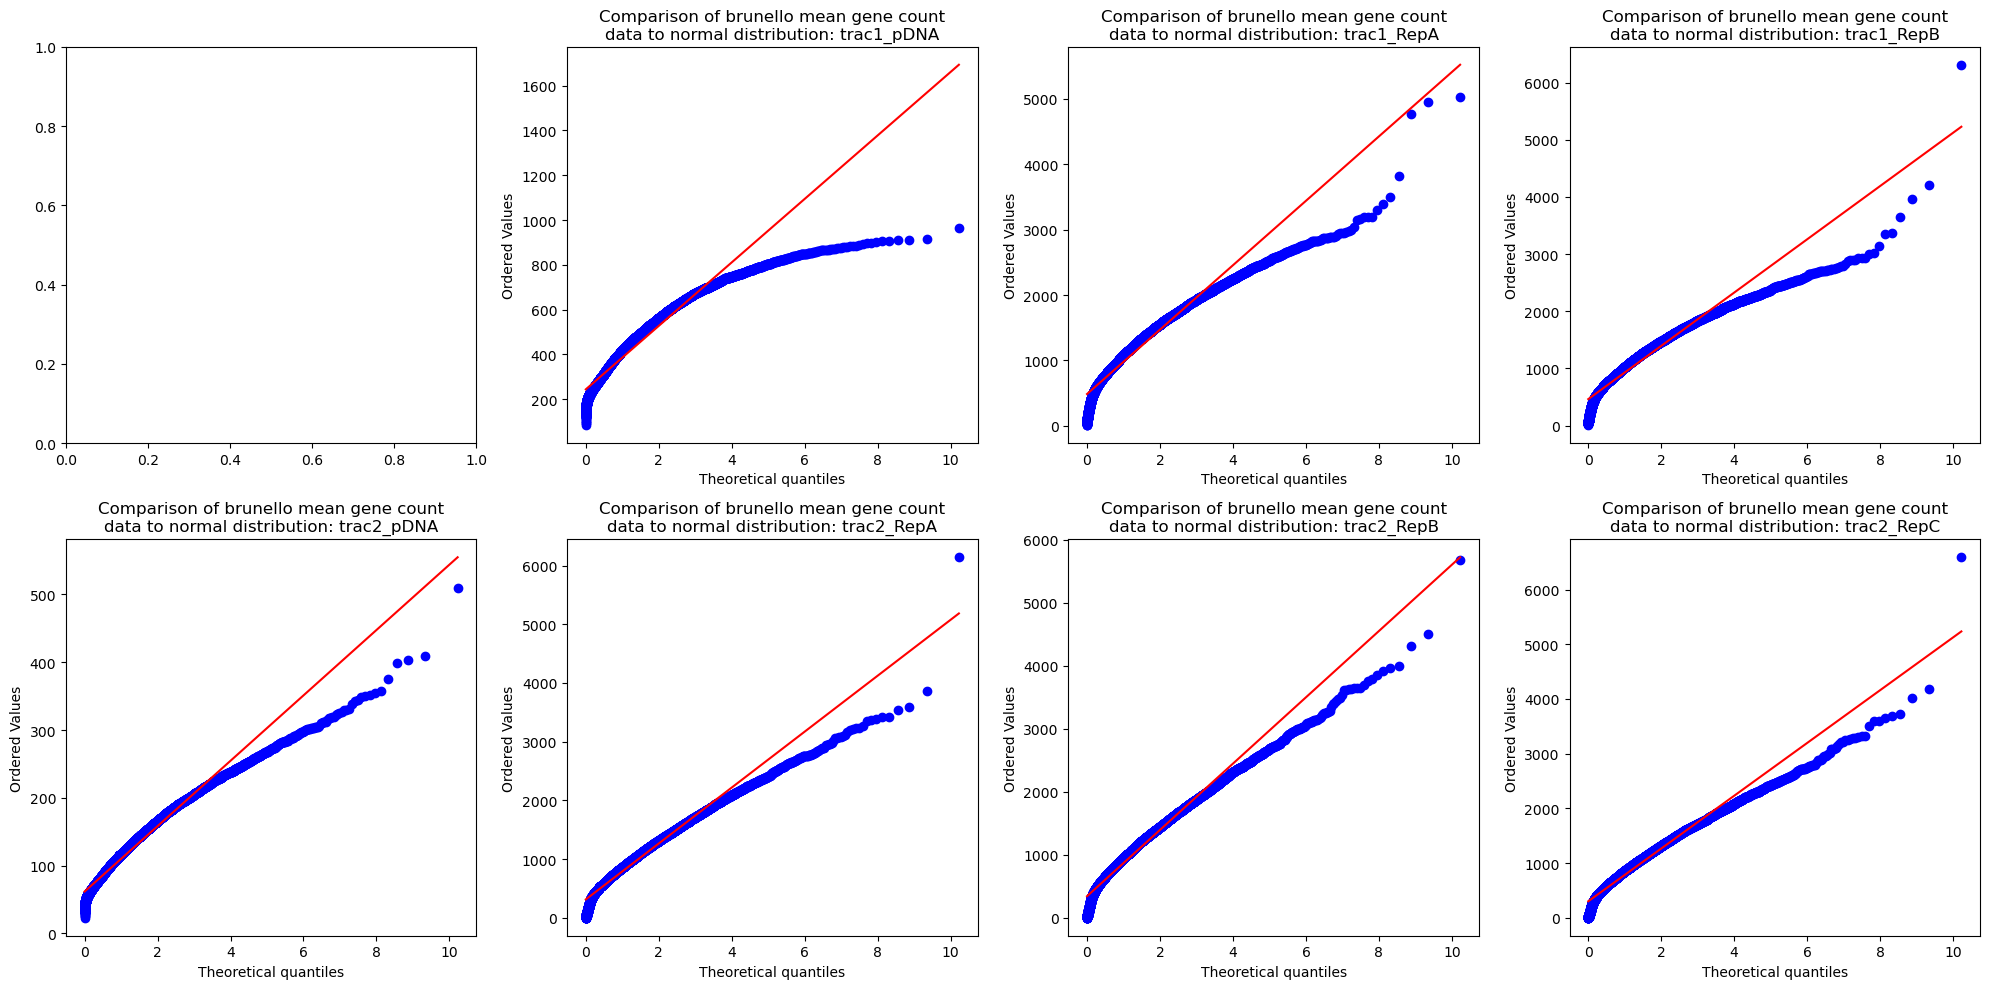

In [123]:
q_q_plots(mean_values, "expon", cols, "Comparison of brunello mean gene count data to normal distribution")
plt.tight_layout()
plt.show()

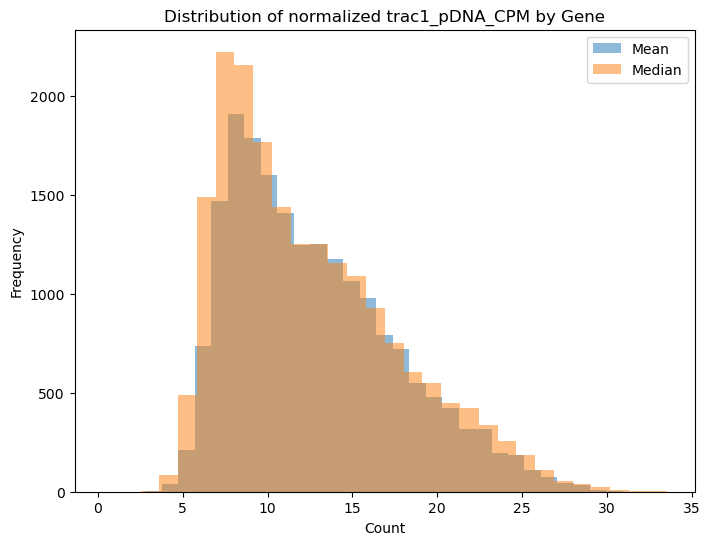

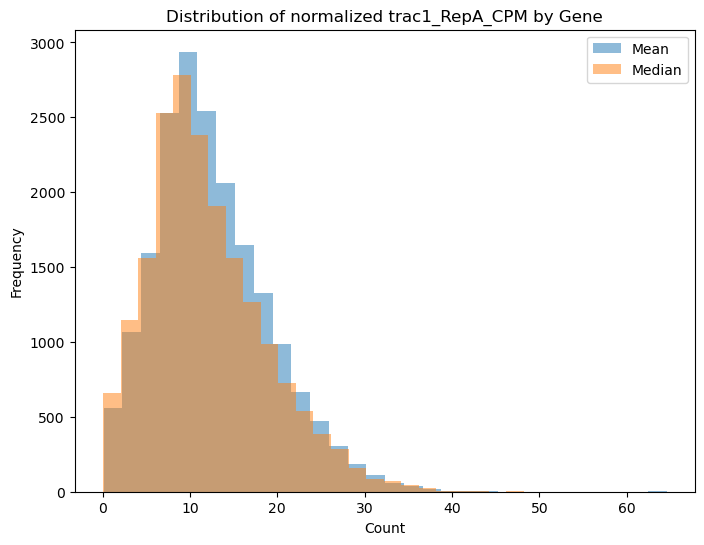

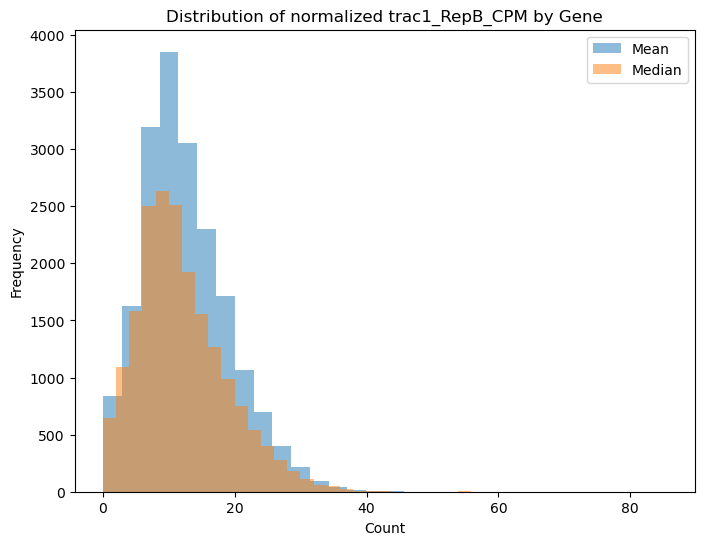

In [124]:
# Calculate mean and median for each count by gene
mean_values = brunello_norm_df.groupby('Target Gene Symbol')[norm_cols].mean()
median_values = brunello_norm_df.groupby('Target Gene Symbol')[norm_cols].median()

show(mean_values.head())
show(median_values.head())
# Plot the distributions
for col in norm_cols:
    plt.figure(figsize=(8, 6))
    plt.hist(mean_values[col], bins=30, alpha=0.5, label='Mean')
    plt.hist(median_values[col], bins=30, alpha=0.5, label='Median')
    plt.xlabel('Count')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of normalized {col} by Gene')
    plt.legend()
    plt.show()

In [125]:
q_q_plots(mean_values, "norm", norm_cols, "Comparison of brunello mean gene count data to normal distribution")
plt.tight_layout()
plt.show()

Processing trac1_pDNA_CPM
Processing trac1_RepA_CPM
Processing trac1_RepB_CPM
Processing trac2_pDNA_CPM
Processing trac2_RepA_CPM
Processing trac2_RepB_CPM
Processing trac2_RepC_CPM


In [126]:
show(brunello_norm_df.head())

Target Gene Symbol
A1BG       95.837869
A1CF        4.410360
A2M        47.017642
A2ML1       9.520441
A3GALT2    39.950976
             ...    
ZYG11A      3.855044
ZYG11B      4.349217
ZYX        16.558226
ZZEF1       6.563171
ZZZ3       13.689792
Name: trac1_pDNA_CPM, Length: 19115, dtype: float64


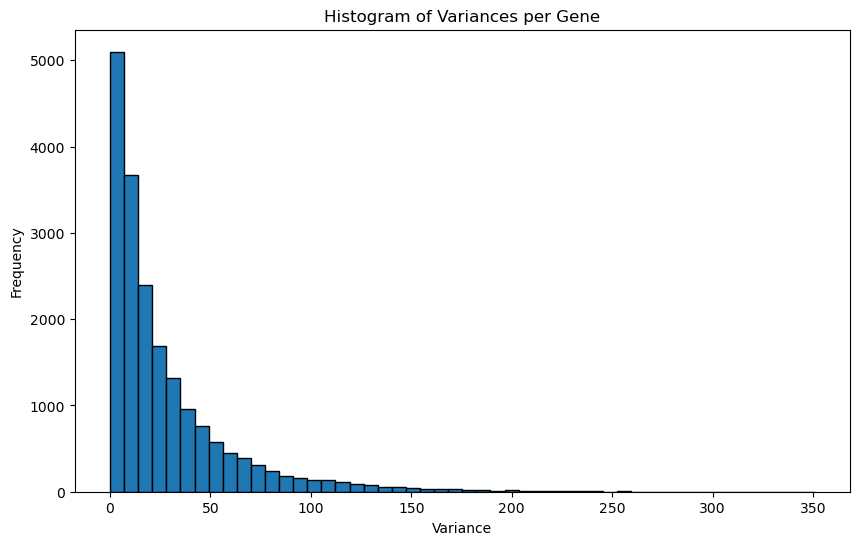

In [133]:
# Group by 'Gene' and calculate the variance of 'Count' for each group
variance_per_gene = brunello_norm_df.groupby('Target Gene Symbol')['trac1_pDNA_CPM'].var()

# Print the variance per gene
print(variance_per_gene)
# Plot the histogram of variances
plt.figure(figsize=(10, 6))
plt.hist(variance_per_gene, bins=50, edgecolor='k')
plt.title('Histogram of Variances per Gene')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.show()

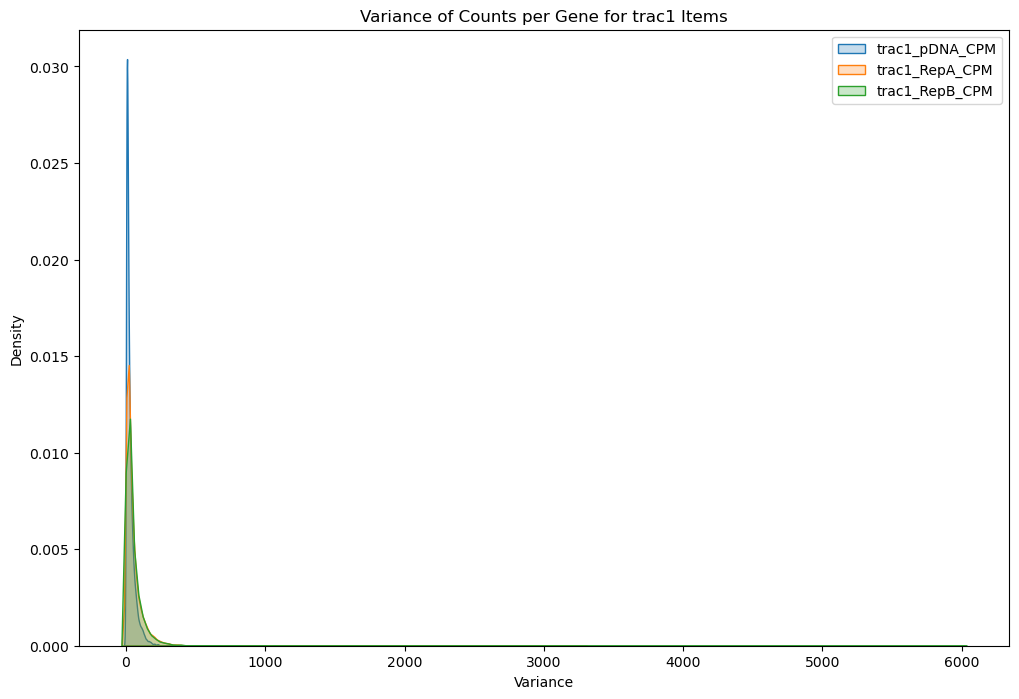

In [139]:
def calculate_and_plot_variance(df, gene_col, count_cols, title):
    """
    Calculate and plot the variance of counts per gene for multiple columns.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    gene_col (str): The name of the column containing gene identifiers.
    count_cols (list): The list of columns containing count data.
    title (str): The title for the plot.
    """
    variances = {}
    
    for count_col in count_cols:
        # Group by 'Gene' and calculate the variance of 'Count' for each group
        variance_per_gene = df.groupby(gene_col)[count_col].var()
        variances[count_col] = variance_per_gene

    # Convert the variances dictionary to a DataFrame for easier plotting
    variances_df = pd.DataFrame(variances)

    # Plot the histogram of variances for each column
    plt.figure(figsize=(12, 8))
    for count_col in count_cols:
        sns.kdeplot(variances_df[count_col].dropna(), label=count_col, fill=True)
    
    plt.title(f'Variance of Counts per Gene for {title}')
    plt.xlabel('Variance')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# List of columns to calculate variance for
trac1_columns = [
    'trac1_pDNA_CPM', 'trac1_RepA_CPM', 'trac1_RepB_CPM'
]

trac2_columns = [
    'trac2_pDNA_CPM', 'trac2_RepA_CPM', 'trac2_RepB_CPM', 'trac2_RepC_CPM'
]

# Calculate and plot variance for trac1 columns
calculate_and_plot_variance(brunello_norm_df, 'Target Gene Symbol', trac1_columns, 'trac1 Items')

# Calculate and plot variance for trac2 columns
calculate_and_plot_variance(brunello_norm_df, 'Target Gene Symbol', trac2_columns, 'trac2 Items')

# Conclusion

* The normalization does seem to do a nice job of bringing the mean and median closer to together. 
* The distribution looks normal in the middle ranges, but not on the tails. 

# Cutting the data

Can we divide the data into different cuts to get something that conforms to a distribution. 

One interesting thing to look at is 'count quartile'- but do things stay in the same quartile across conditions?

Will do this just for normalized data now

look at trac1 and trac2 separately

# Look at distributions of quartiles

Not enough subplots for all quartiles, some plots may be missing.


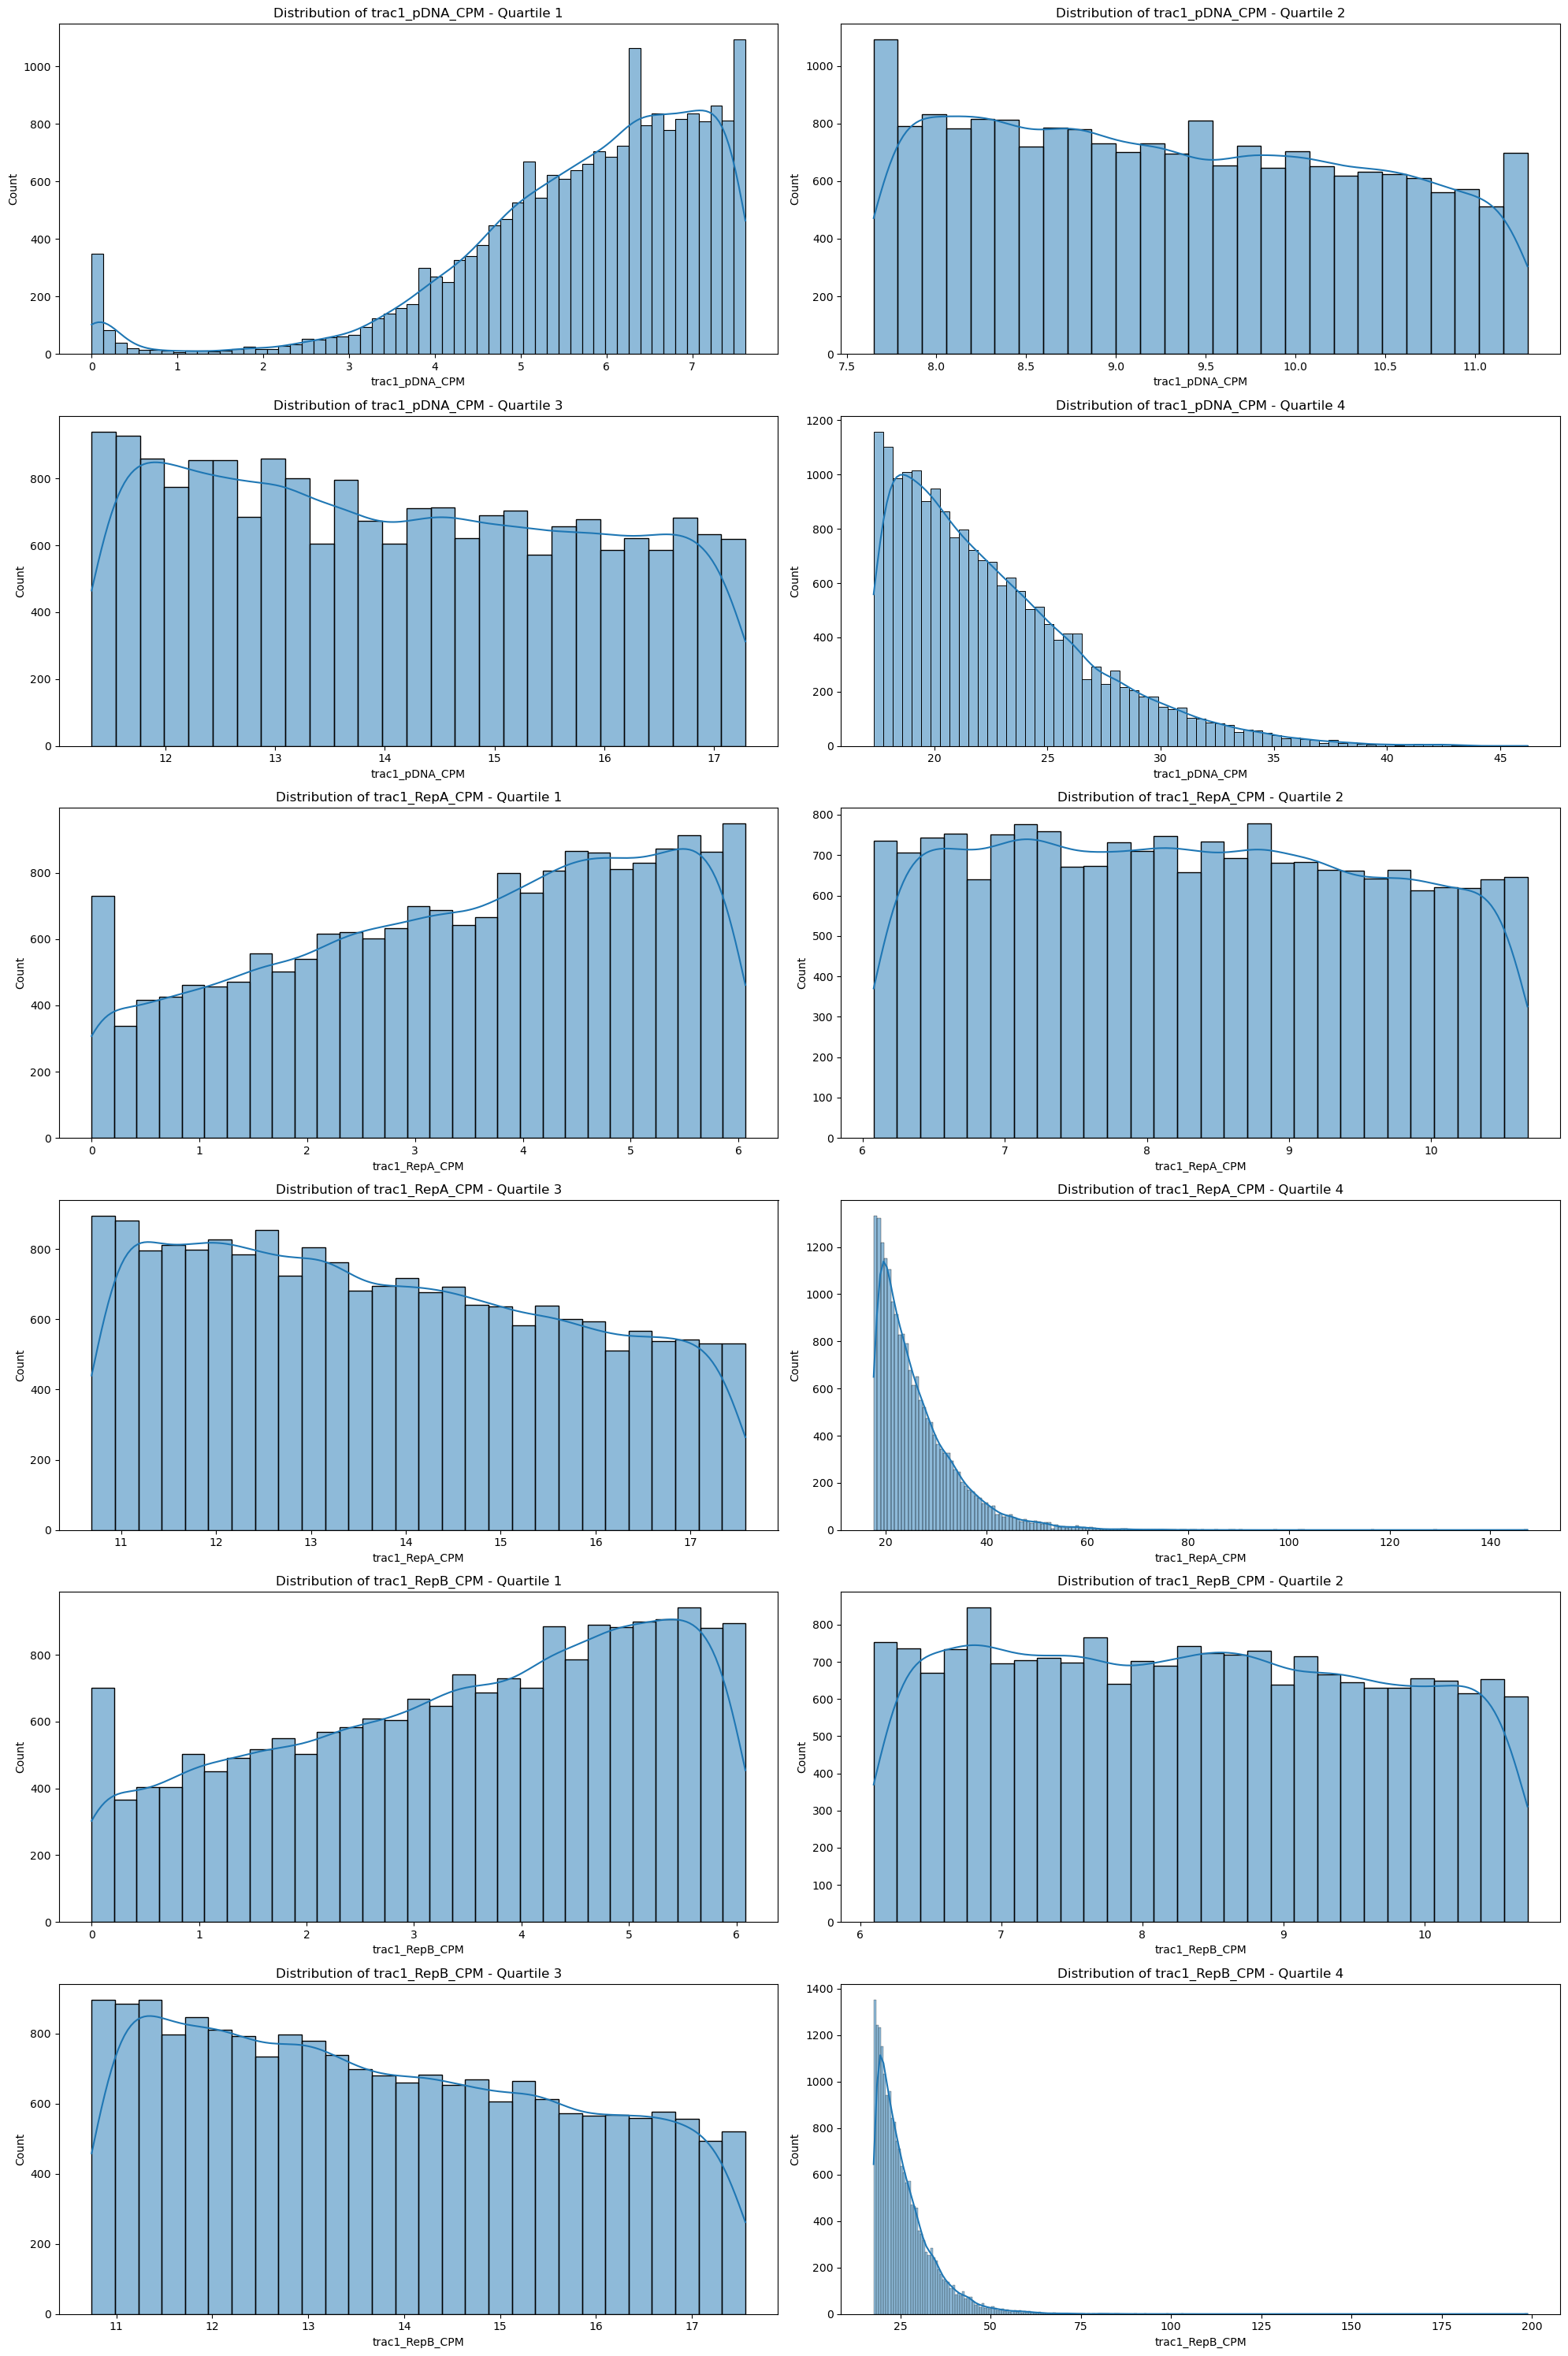

In [145]:
cols=['trac1_pDNA_CPM', 'trac1_RepA_CPM', 'trac1_RepB_CPM']
quart_cols=['trac1_pDNA_CPM_quartile', 'trac1_RepA_CPM_quartile', 'trac1_RepB_CPM_quartile']

trac1_df=brunello_norm_df[cols].copy()
trac1_df=calculate_quartiles(trac1_df, cols)
dist_plots_by_quartile(trac1_df, cols, quart_cols)
plt.tight_layout()
plt.show()

In [146]:
cols=['trac2_pDNA_CPM', 'trac2_RepA_CPM', 'trac2_RepB_CPM', 'trac2_RepC_CPM']
quart_cols=['trac2_pDNA_CPM_quartile', 'trac2_RepA_CPM_quartile', 'trac2_RepB_CPM_quartile', 'trac2_RepC_CPM_quartile']

trac2_df=brunello_norm_df[cols].copy()
trac2_df=calculate_quartiles(trac2_df, cols)
dist_plots_by_quartile(trac2_df, cols, quart_cols)
plt.tight_layout()
plt.show()

Not enough subplots for all quartiles, some plots may be missing.


In [147]:
trac1_cols = ['trac1_pDNA_CPM', 'trac1_RepA_CPM', 'trac1_RepB_CPM']
trac1_df = brunello_norm_df[trac1_cols + ['sgRNA Sequence', 'Target Gene ID', 'Target Gene Symbol', 'Target Transcript', 'Genomic Sequence', 'Position of Base After Cut (1-based)', 'Strand', 'sgRNA Target Sequence', 'Target Context Sequence', 'PAM Sequence', 'Exon Number', 'Rule Set 2 score', 'Tx Length', 'Gene Isoform Count', 'Annotation']].copy()
show(trac1_df.head())

In [148]:
trac2_cols = ['trac2_pDNA_CPM', 'trac2_RepA_CPM', 'trac2_RepB_CPM', 'trac2_RepC_CPM']
trac2_df = brunello_norm_df[trac2_cols + ['sgRNA Sequence', 'Target Gene ID', 'Target Gene Symbol', 'Target Transcript', 'Genomic Sequence', 'Position of Base After Cut (1-based)', 'Strand', 'sgRNA Target Sequence', 'Target Context Sequence', 'PAM Sequence', 'Exon Number', 'Rule Set 2 score', 'Tx Length', 'Gene Isoform Count', 'Annotation']].copy()
show(trac2_df.head())

In [149]:
# Divide trac1_df into quartiles based on trac1_pDNA_CPM
trac1_df['pDNA_CPM_quartile'] = pd.qcut(trac1_df['trac1_pDNA_CPM'], q=4, labels=False)
trac1_df['RepA_CPM_quartile'] = pd.qcut(trac1_df['trac1_RepA_CPM'], q=4, labels=False)
trac1_df['RepB_CPM_quartile'] = pd.qcut(trac1_df['trac1_RepB_CPM'], q=4, labels=False)
show(trac1_df)


In [150]:
pDNA_repA_quartile_change_count = trac1_df[trac1_df['pDNA_CPM_quartile'] != trac1_df['RepA_CPM_quartile']]
pct=len(pDNA_repA_quartile_change_count.index)/len(trac1_df) * 100
print(f"Number of trac1 guides that change quartile between pDNA and RepA: {len(pDNA_repA_quartile_change_count.index)} ({pct:.2f}) of {len(trac1_df.index)}")

Number of trac1 guides that change quartile between pDNA and RepA: 37208 (48.05) of 77441


In [151]:
pDNA_repB_quartile_change_count = trac1_df[trac1_df['pDNA_CPM_quartile'] != trac1_df['RepB_CPM_quartile']]
pct=len(pDNA_repB_quartile_change_count.index)/len(trac1_df) * 100
print(f"Number of trac1 guides that change quartile pDNA and RepB: {len(pDNA_repB_quartile_change_count.index)} ({pct:.2f}) of {len(trac1_df.index)}")

Number of trac1 guides that change quartile pDNA and RepB: 37162 (47.99) of 77441


In [152]:
repA_repB_quartile_change_count=trac1_df[trac1_df['RepA_CPM_quartile'] != trac1_df['RepB_CPM_quartile']]
pct=len(repA_repB_quartile_change_count.index)/len(trac1_df) * 100
print(f"Number of trac1 guides that change quartile RepA and RepB: {len(repA_repB_quartile_change_count.index)} ({pct:.2f}) of {len(trac1_df.index)}")

Number of trac1 guides that change quartile RepA and RepB: 28126 (36.32) of 77441


In [153]:
#Can we look at the direction of the change?
#Calculate change direction between pDNA and RepA
trac1_df['pDNA_to_RepA_change'] = trac1_df.apply(lambda row: 'up' if row['RepA_CPM_quartile'] > row['pDNA_CPM_quartile'] else ('down' if row['RepA_CPM_quartile'] < row['pDNA_CPM_quartile'] else 'same'), axis=1)
show(trac1_df.head())

In [154]:
#Calculate change direction between pDNA and RepA
trac1_df['pDNA_to_RepB_change'] = trac1_df.apply(lambda row: 'up' if row['RepB_CPM_quartile'] > row['pDNA_CPM_quartile'] else ('down' if row['RepB_CPM_quartile'] < row['pDNA_CPM_quartile'] else 'same'), axis=1)
trac1_df['RepA_to_RepB_change'] = trac1_df.apply(lambda row: 'up' if row['RepB_CPM_quartile'] > row['RepA_CPM_quartile'] else ('down' if row['RepB_CPM_quartile'] < row['RepA_CPM_quartile'] else 'same'), axis=1)
show(trac1_df.head())

In [159]:
pDNA_RepA_vc=trac1_df['pDNA_to_RepA_change'].value_counts()

In [156]:
pDNA_RepB_vc=trac1_df['pDNA_to_RepB_change'].value_counts()

In [157]:
RepA_RepB_vc=trac1_df['RepA_to_RepB_change'].value_counts()

In [160]:
all_changes=pd.DataFrame({'pDNA_RepA': pDNA_RepA_vc, 'pDNA_RepB': pDNA_RepB_vc, 'RepA_RepB': RepA_RepB_vc})

# Plot
all_changes.plot(kind='bar')
plt.title('trac1 Change Counts Comparison')
plt.xlabel('Change Type')
plt.ylabel('Counts')
plt.xticks(rotation=0)  # Keep the labels on the x-axis readable
plt.legend(title='Columns')
plt.show()

# Conclusion

There are a decent number of guides that change quartile, you might expect more of this between pDNA (start) and RepA or RepB- but you would want more consistency between RepA and RepB. 

In [161]:
unique_guide_actions_per_gene=trac1_df.groupby('Target Gene Symbol')['RepA_to_RepB_change'].nunique()

# Filter genes with more than one unique guide action
genes_with_different_guides = unique_guide_actions_per_gene[unique_guide_actions_per_gene > 1]

# Get the count of such genes
num_genes_with_different_guides = len(genes_with_different_guides)

# Print the result
print(f"The number of genes with guides that act differently between RepA and RepB: {num_genes_with_different_guides}")

The number of genes with guides that act differently between RepA and RepB: 15353


In [162]:
unique_guide_actions_per_gene=trac1_df.groupby('Target Gene Symbol')['pDNA_to_RepA_change'].nunique()

# Filter genes with more than one unique guide action
genes_with_different_guides = unique_guide_actions_per_gene[unique_guide_actions_per_gene > 1]

# Get the count of such genes
num_genes_with_different_guides = len(genes_with_different_guides)

# Print the result
print(f"The number of genes with guides that act differently between pDNA and RepA: {num_genes_with_different_guides}")

The number of genes with guides that act differently between pDNA and RepA: 16226


In [163]:
unique_guide_actions_per_gene=trac1_df.groupby('Target Gene Symbol')['pDNA_to_RepB_change'].nunique()

# Filter genes with more than one unique guide action
genes_with_different_guides = unique_guide_actions_per_gene[unique_guide_actions_per_gene > 1]

# Get the count of such genes
num_genes_with_different_guides = len(genes_with_different_guides)

# Print the result
print(f"The number of genes with guides that act differently between pDNA and RepB: {num_genes_with_different_guides}")

The number of genes with guides that act differently between pDNA and RepB: 16164


# Conclusion

Most genes have guides in different quartiles. 

There are 19,115 total genes.

* 15,353 of these have guides in different quartiles between RepA and RepB
* 16,226 of these have guides in different quartiles between pDNA and RepA
* 16,164 of these have guides in different quartiles between pDNA and RepA

In [164]:
show(trac2_df.head())

In [165]:
#Do this for trac2

trac2_df['pDNA_CPM_quartile'] = pd.qcut(trac2_df['trac2_pDNA_CPM'], q=4, labels=False)
trac2_df['RepA_CPM_quartile'] = pd.qcut(trac2_df['trac2_RepA_CPM'], q=4, labels=False)
trac2_df['RepB_CPM_quartile'] = pd.qcut(trac2_df['trac2_RepB_CPM'], q=4, labels=False)
trac2_df['RepC_CPM_quartile'] = pd.qcut(trac2_df['trac2_RepC_CPM'], q=4, labels=False )
show(trac2_df)

In [166]:
#Calculate change direction between conditions
trac2_df['pDNA_to_RepA_change'] = trac2_df.apply(lambda row: 'up' if row['RepA_CPM_quartile'] > row['pDNA_CPM_quartile'] else ('down' if row['RepA_CPM_quartile'] < row['pDNA_CPM_quartile'] else 'same'), axis=1)
trac2_df['pDNA_to_RepB_change'] = trac2_df.apply(lambda row: 'up' if row['RepB_CPM_quartile'] > row['pDNA_CPM_quartile'] else ('down' if row['RepB_CPM_quartile'] < row['pDNA_CPM_quartile'] else 'same'), axis=1)
trac2_df['pDNA_to_RepC_change'] = trac2_df.apply(lambda row: 'up' if row['RepC_CPM_quartile'] > row['pDNA_CPM_quartile'] else ('down' if row['RepC_CPM_quartile'] < row['pDNA_CPM_quartile'] else 'same'), axis=1)
trac2_df['RepA_to_RepB_change'] = trac2_df.apply(lambda row: 'up' if row['RepB_CPM_quartile'] > row['RepA_CPM_quartile'] else ('down' if row['RepB_CPM_quartile'] < row['RepA_CPM_quartile'] else 'same'), axis=1)
trac2_df['RepA_to_RepC_change'] = trac2_df.apply(lambda row: 'up' if row['RepC_CPM_quartile'] > row['RepA_CPM_quartile'] else ('down' if row['RepC_CPM_quartile'] < row['RepA_CPM_quartile'] else 'same'), axis=1)
trac2_df['RepB_to_RepC_change'] = trac2_df.apply(lambda row: 'up' if row['RepC_CPM_quartile'] > row['RepB_CPM_quartile'] else ('down' if row['RepC_CPM_quartile'] < row['RepB_CPM_quartile'] else 'same'), axis=1)
show(trac2_df.head())

In [167]:
pDNA_RepA_vc=trac2_df['pDNA_to_RepA_change'].value_counts()
pDNA_RepB_vc=trac2_df['pDNA_to_RepB_change'].value_counts()
pDNA_RepC_vc=trac2_df['pDNA_to_RepC_change'].value_counts()
RepA_RepB_vc=trac2_df['RepA_to_RepB_change'].value_counts()
RepA_RepC_vc=trac2_df['RepA_to_RepC_change'].value_counts()
RepB_RepC_vc=trac2_df['RepB_to_RepC_change'].value_counts()

In [168]:
all_changes=pd.DataFrame({'pDNA_RepA': pDNA_RepA_vc, 'pDNA_RepB': pDNA_RepB_vc, 'pDNA_RepC': pDNA_RepC_vc, 
                          'RepA_RepB': RepA_RepB_vc, 'RepA_RepC': RepA_RepC_vc, 'RepB_RepC': RepB_RepC_vc})

# Plot
all_changes.plot(kind='bar')
plt.title('trac2 Change Counts Comparison')
plt.xlabel('Change Type')
plt.ylabel('Counts')
plt.xticks(rotation=0)  # Keep the labels on the x-axis readable
plt.legend(title='Columns')
plt.show()

In [169]:
unique_guide_actions_per_gene=trac2_df.groupby('Target Gene Symbol')['RepA_to_RepB_change'].nunique()

# Filter genes with more than one unique guide action
genes_with_different_guides = unique_guide_actions_per_gene[unique_guide_actions_per_gene > 1]

# Get the count of such genes
num_genes_with_different_guides = len(genes_with_different_guides)

# Print the result
print(f"trac2: The number of genes with guides that act differently between RepA and RepB: {num_genes_with_different_guides}")

trac2: The number of genes with guides that act differently between RepA and RepB: 15589


In [170]:
unique_guide_actions_per_gene=trac2_df.groupby('Target Gene Symbol')['RepA_to_RepC_change'].nunique()

# Filter genes with more than one unique guide action
genes_with_different_guides = unique_guide_actions_per_gene[unique_guide_actions_per_gene > 1]

# Get the count of such genes
num_genes_with_different_guides = len(genes_with_different_guides)

# Print the result
print(f"trac2: The number of genes with guides that act differently between RepB and RepC: {num_genes_with_different_guides}")

trac2: The number of genes with guides that act differently between RepB and RepC: 16066


In [171]:
unique_guide_actions_per_gene=trac2_df.groupby('Target Gene Symbol')['pDNA_to_RepA_change'].nunique()

# Filter genes with more than one unique guide action
genes_with_different_guides = unique_guide_actions_per_gene[unique_guide_actions_per_gene > 1]

# Get the count of such genes
num_genes_with_different_guides = len(genes_with_different_guides)

# Print the result
print(f"trac2: The number of genes with guides that act differently between pDNA and RepA: {num_genes_with_different_guides}")

trac2: The number of genes with guides that act differently between pDNA and RepA: 17003


In [172]:
unique_guide_actions_per_gene=trac2_df.groupby('Target Gene Symbol')['pDNA_to_RepB_change'].nunique()

# Filter genes with more than one unique guide action
genes_with_different_guides = unique_guide_actions_per_gene[unique_guide_actions_per_gene > 1]

# Get the count of such genes
num_genes_with_different_guides = len(genes_with_different_guides)

# Print the result
print(f"trac2: The number of genes with guides that act differently between pDNA and RepB: {num_genes_with_different_guides}")

trac2: The number of genes with guides that act differently between pDNA and RepB: 16943


In [173]:
unique_guide_actions_per_gene=trac2_df.groupby('Target Gene Symbol')['pDNA_to_RepC_change'].nunique()

# Filter genes with more than one unique guide action
genes_with_different_guides = unique_guide_actions_per_gene[unique_guide_actions_per_gene > 1]

# Get the count of such genes
num_genes_with_different_guides = len(genes_with_different_guides)

# Print the result
print(f"trac2: The number of genes with guides that act differently between pDNA and RepC: {num_genes_with_different_guides}")

trac2: The number of genes with guides that act differently between pDNA and RepC: 17049


# Conclusion

Things look pretty much the same between trac1 and trac2 with respect to the number of genes with guides in different quartiles. 

In [174]:
#What is the annotation in each quartile

quartile_columns = ['pDNA_CPM_quartile', 'RepA_CPM_quartile', 'RepB_CPM_quartile', 'RepC_CPM_quartile']
quartiles=[0,1,2,3]
for column in quartile_columns:
    for quartile in quartiles:
        filtered_df = trac2_df[trac2_df[column] == quartile]
        counts = filtered_df['Annotation'].value_counts()
        print(f"Annotation counts for Quartile {quartile}:")
        print(counts)
        print()


Annotation counts for Quartile 0:
Annotation
Uncategorized    18831
NonEssential       885
Essential          225
Name: count, dtype: int64

Annotation counts for Quartile 1:
Annotation
Uncategorized    17785
NonEssential       882
Essential          205
Name: count, dtype: int64

Annotation counts for Quartile 2:
Annotation
Uncategorized    18378
NonEssential       810
Essential          209
Name: count, dtype: int64

Annotation counts for Quartile 3:
Annotation
Uncategorized    18189
NonEssential       853
Essential          189
Name: count, dtype: int64

Annotation counts for Quartile 0:
Annotation
Uncategorized    18086
Essential          725
NonEssential       584
Name: count, dtype: int64

Annotation counts for Quartile 1:
Annotation
Uncategorized    18401
NonEssential       880
Essential           70
Name: count, dtype: int64

Annotation counts for Quartile 2:
Annotation
Uncategorized    18368
NonEssential       951
Essential           22
Name: count, dtype: int64

Annotation co

# Conclusion

There is a different in the number of NonEssential and Essential genes in each quartile, as expected. It is unclear if this is statistically significant. 

In [175]:
show(brunello_norm_df.head())

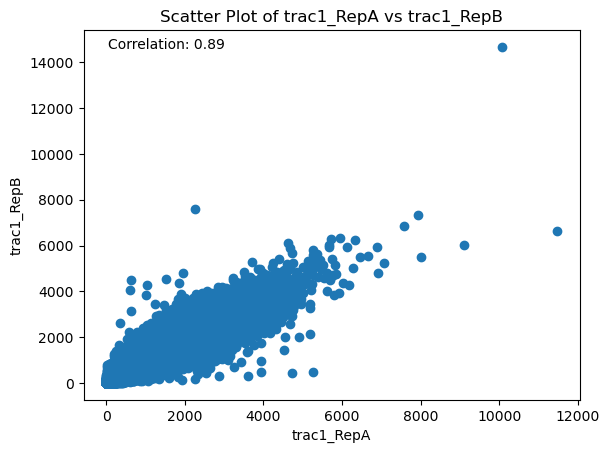

In [176]:

# Calculate correlation
corr = brunello_norm_df['trac1_RepA'].corr(brunello_norm_df['trac1_RepB'])

# Create scatter plot
plt.scatter(brunello_norm_df['trac1_RepA'], brunello_norm_df['trac1_RepB'])

# Annotate correlation
plt.annotate(f"Correlation: {corr:.2f}", xy=(0.05, 0.95), xycoords='axes fraction')

# Set labels and title
plt.xlabel('trac1_RepA')
plt.ylabel('trac1_RepB')
plt.title('Scatter Plot of trac1_RepA vs trac1_RepB')

# Show the plot
plt.show()

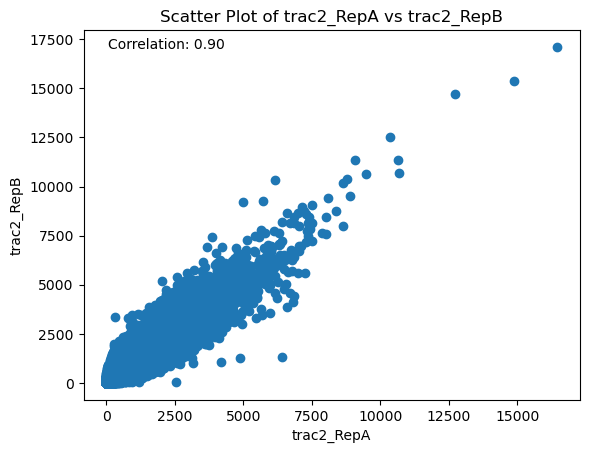

In [177]:

# Calculate correlation
corr = brunello_norm_df['trac2_RepA'].corr(brunello_norm_df['trac2_RepB'])

# Create scatter plot
plt.scatter(brunello_norm_df['trac2_RepA'], brunello_norm_df['trac2_RepB'])

# Annotate correlation
plt.annotate(f"Correlation: {corr:.2f}", xy=(0.05, 0.95), xycoords='axes fraction')

# Set labels and title
plt.xlabel('trac2_RepA')
plt.ylabel('trac2_RepB')
plt.title('Scatter Plot of trac2_RepA vs trac2_RepB')

# Show the plot
plt.show()

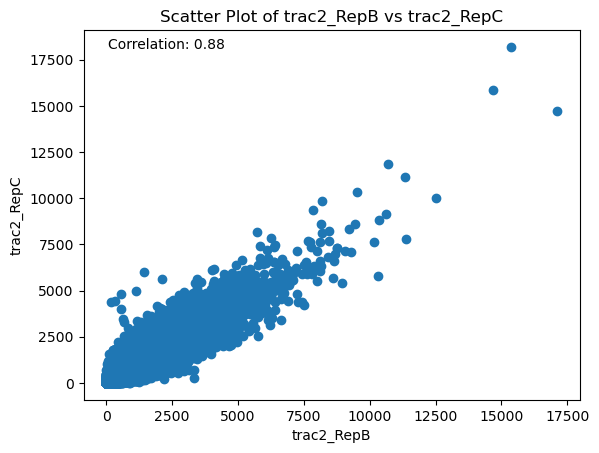

In [179]:

# Calculate correlation
corr = brunello_norm_df['trac2_RepB'].corr(brunello_norm_df['trac2_RepC'])

# Create scatter plot
plt.scatter(brunello_norm_df['trac2_RepB'], brunello_norm_df['trac2_RepC'])

# Annotate correlation
plt.annotate(f"Correlation: {corr:.2f}", xy=(0.05, 0.95), xycoords='axes fraction')

# Set labels and title
plt.xlabel('trac2_RepB')
plt.ylabel('trac2_RepC')
plt.title('Scatter Plot of trac2_RepB vs trac2_RepC')

# Show the plot
plt.show()

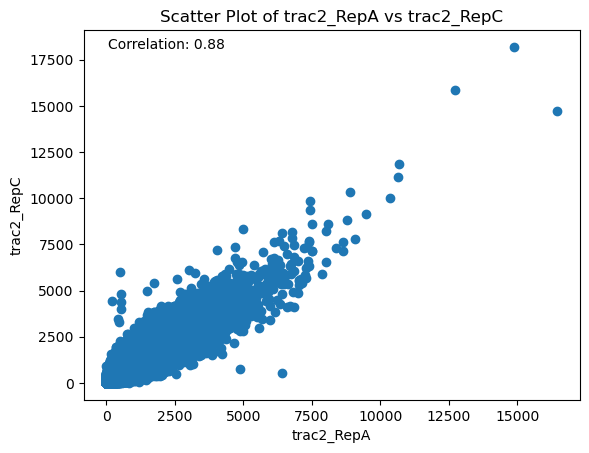

In [180]:
# Calculate correlation
corr = brunello_norm_df['trac2_RepA'].corr(brunello_norm_df['trac2_RepC'])

# Create scatter plot
plt.scatter(brunello_norm_df['trac2_RepA'], brunello_norm_df['trac2_RepC'])

# Annotate correlation
plt.annotate(f"Correlation: {corr:.2f}", xy=(0.05, 0.95), xycoords='axes fraction')

# Set labels and title
plt.xlabel('trac2_RepA')
plt.ylabel('trac2_RepC')
plt.title('Scatter Plot of trac2_RepA vs trac2_RepC')

# Show the plot
plt.show()

In [181]:
show(brunello_norm_df['Annotation'].value_counts())

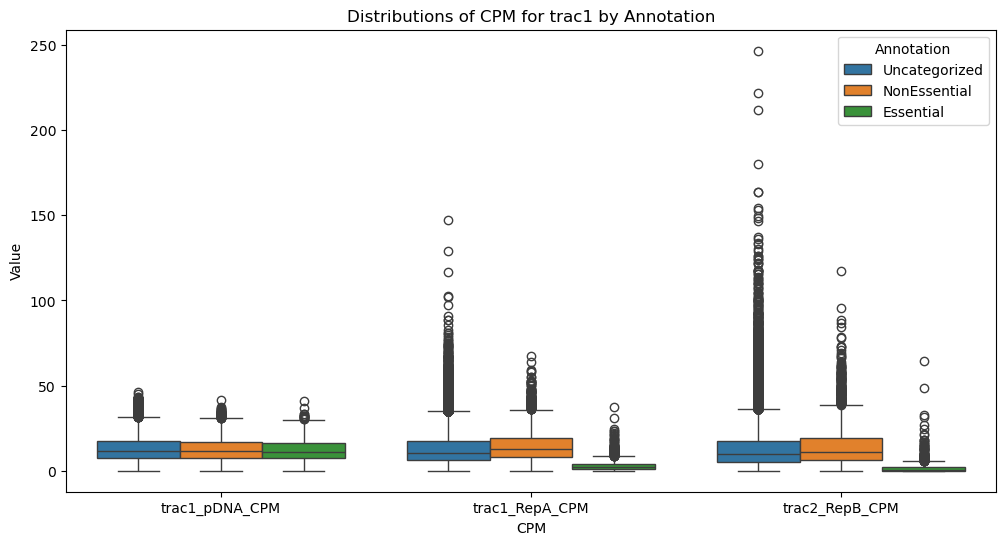

In [183]:
# Select the columns of interest
columns = ['trac1_pDNA_CPM', 'trac1_RepA_CPM', 'trac2_RepB_CPM', 'Annotation']

# Create a new dataframe with the selected columns
df_selected = brunello_norm_df[columns]

# Melt the dataframe to convert it to long format
df_melted = df_selected.melt(id_vars='Annotation', var_name='CPM', value_name='Value')

# Plot the distributions using boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x='CPM', y='Value', hue='Annotation')
plt.title('Distributions of CPM for trac1 by Annotation')
plt.xlabel('CPM')
plt.ylabel('Value')
plt.show()

In [184]:
# Select the columns of interest
columns = ['trac2_pDNA_CPM', 'trac2_RepA_CPM', 'trac2_RepB_CPM', 'trac2_RepC_CPM', 'Annotation']

# Create a new dataframe with the selected columns
df_selected = brunello_norm_df[columns]

# Melt the dataframe to convert it to long format
df_melted = df_selected.melt(id_vars='Annotation', var_name='CPM', value_name='Value')

# Plot the distributions using boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x='CPM', y='Value', hue='Annotation')
plt.title('Distributions of CPM for trac2 by Annotation')
plt.xlabel('CPM')
plt.ylabel('Value')
plt.show()

# Conclusions

* The distribution by Annotation looks pretty similar for the pDNA (which is hte starting material).
* the essential genes seem to drop (which is expected)
* There seem to be some differences between the 'NonEssential' and 'Uncategorized' - suggestions there is some missing information.

# Look at Israeli data

In [185]:
israeli_df=pd.read_csv(israeli, header=0, delimiter="\t")
show(israeli_df.head())

In [186]:
is_cols=['WT', 'Alpha_1', 'Alpha_2', 'Beta_1', 'Beta_2', 'Uninfected_1', 'Uninfected_2', 'Input_1', 'Input_2']
#for col in cols:
#    total_counts = brunello_df[col].sum()
#    normalized_col_name = col + '_CPM'  # Create a new column name for the normalized data
#    brunello_df[normalized_col_name] = (brunello_df[col] / total_counts) * 1_000_000

for col in is_cols:
    israeli_norm_df=cal_cpm(israeli_df, col)

del israeli_df

show(israeli_norm_df)

# Not at guide level

Sadly, the Israeli data is not at the guide level, but at the gene level. 

Will plot distributions, but this si probably not as useful, though, I can aggregate counts in the Brunello data at the gene level and see if the distributions look the same.

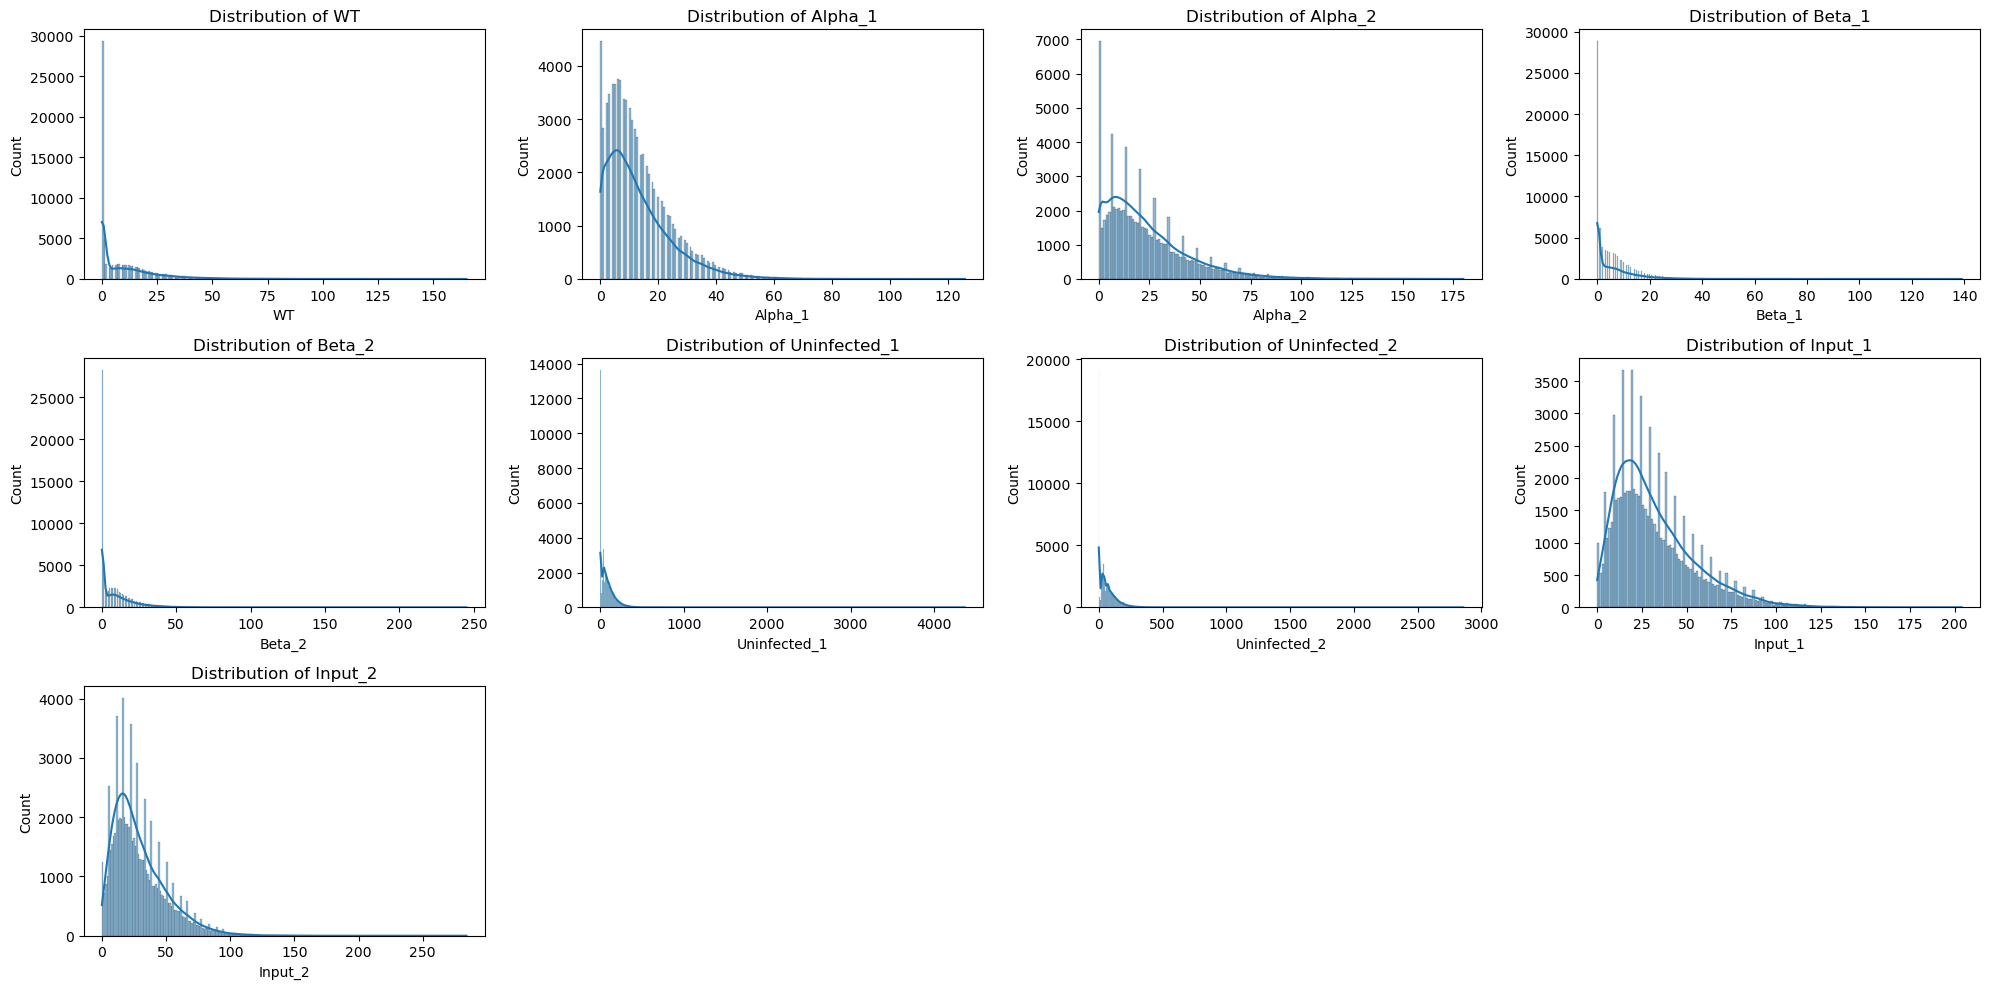

In [187]:
dist_plots(israeli_norm_df, is_cols)

plt.tight_layout()
plt.show()

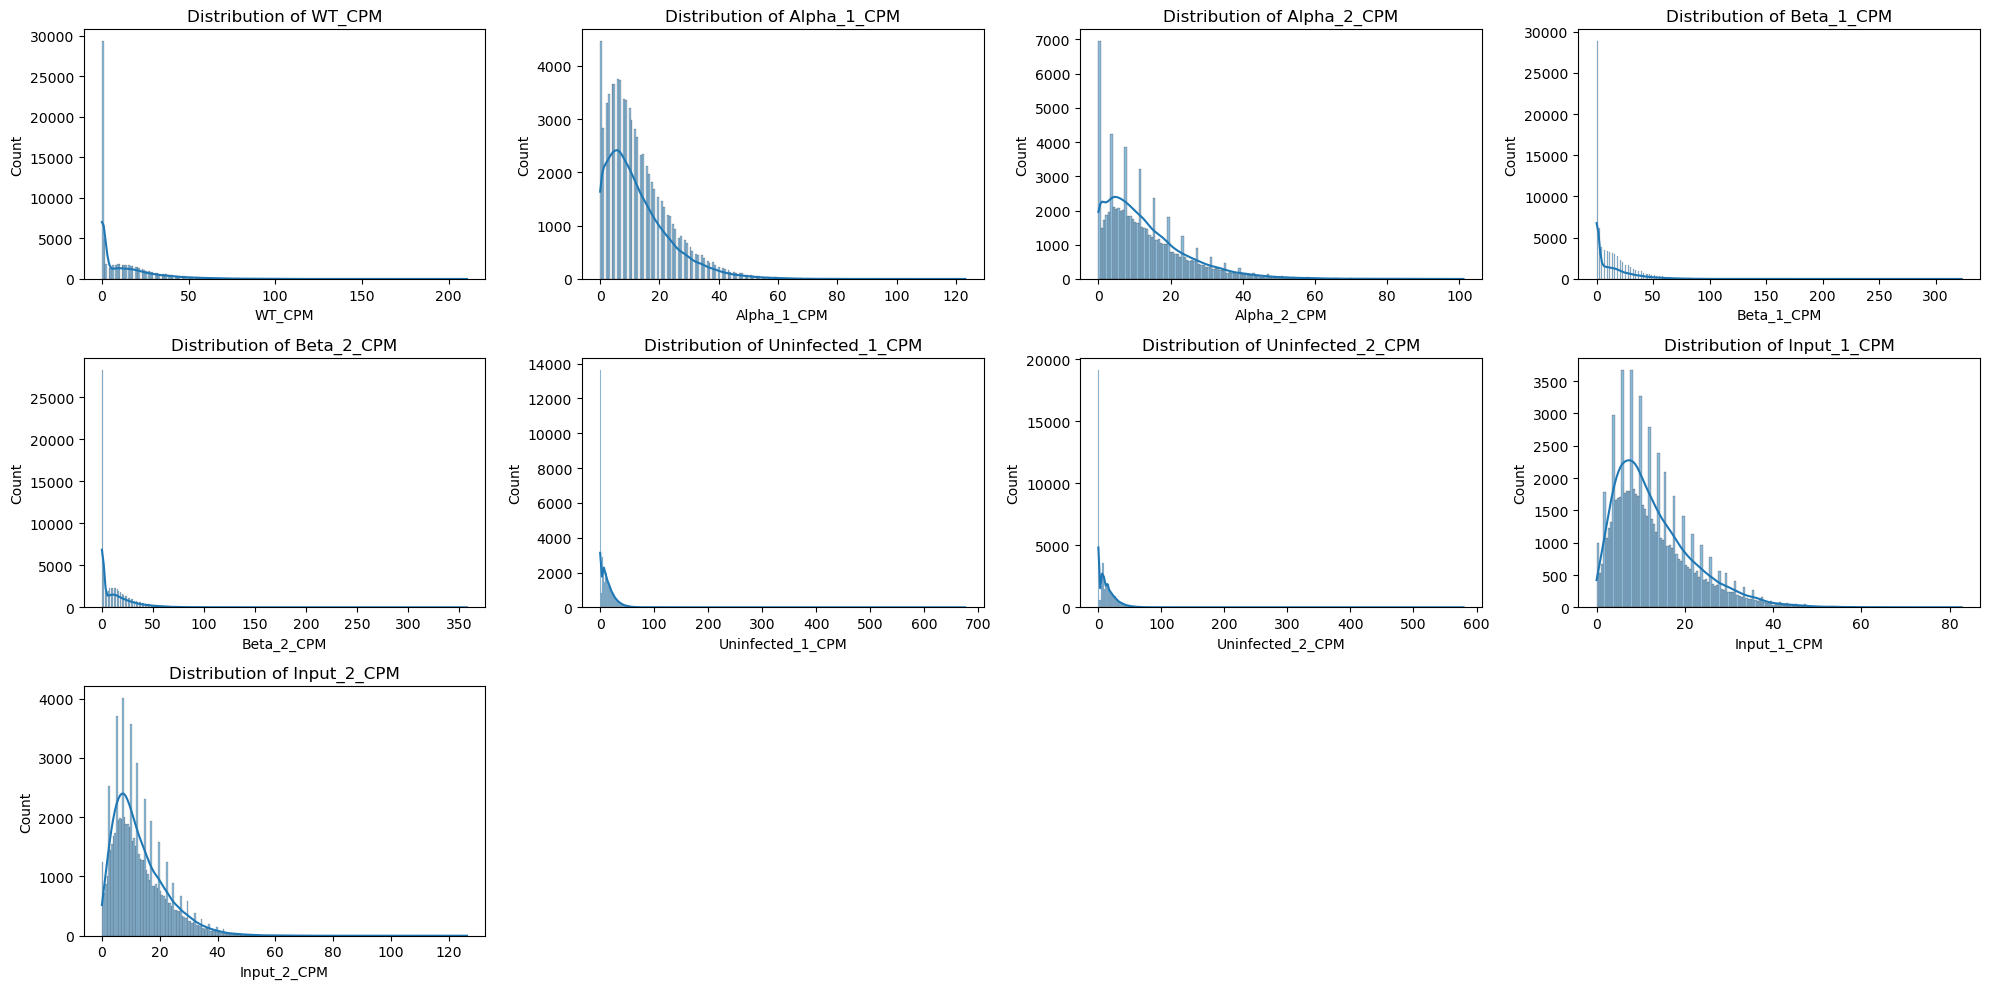

In [188]:
is_norm_cols=[col + '_CPM' for col in is_cols]
dist_plots(israeli_norm_df, is_norm_cols)
plt.tight_layout()
plt.show()

In [189]:
israeli_norm_df.columns

Index(['sgRNA', 'Gene', 'WT', 'Alpha_1', 'Alpha_2', 'Beta_1', 'Beta_2',
       'Uninfected_1', 'Uninfected_2', 'Input_1', 'Input_2', 'WT_CPM',
       'Alpha_1_CPM', 'Alpha_2_CPM', 'Beta_1_CPM', 'Beta_2_CPM',
       'Uninfected_1_CPM', 'Uninfected_2_CPM', 'Input_1_CPM', 'Input_2_CPM'],
      dtype='object')

In [190]:
q_q_plots(israeli_norm_df, "norm", is_cols, "Comparison of israeli raw gene data to normal distribution")
plt.tight_layout()
plt.show()

Processing WT
Processing Alpha_1
Processing Alpha_2
Processing Beta_1
Processing Beta_2
Processing Uninfected_1
Processing Uninfected_2
Processing Input_1
Processing Input_2


# Conclusion

Because the Israeli data is at the gene level, I don't think it is worth doing too much more with this. However, it is interesting to see the Q-Q plots looks similiar to the Brunello guide level data. 

# Conclusion: Entire dataset distributions

* For the 'control' (that is the plasmid library prior to being put into cells): the distribution looks different at different ends of the plot. 
* The test data (that is cells that have been subject to selection) have distributions that look different from the control. 
* Plotting the distributions of the different quartiels shows the differences in the distributions
    * Is it possible to use different models depending on where things are in the distribution.
* There are differences in Nonessential and Essential genes in the different quartiles, though surprisingly there are still some essential genes in the highest quartile. 


# System info

In [191]:
!conda list

# packages in environment at /Users/deannachurch/opt/anaconda3/envs/sb_capstone:
#
# Name                    Version                   Build  Channel
annotated-types           0.7.0              pyhd8ed1ab_0    conda-forge
anyio                     4.4.0              pyhd8ed1ab_0    conda-forge
appnope                   0.1.4              pyhd8ed1ab_0    conda-forge
argon2-cffi               23.1.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0          py312h02f2b3b_4    conda-forge
arrow                     1.3.0              pyhd8ed1ab_0    conda-forge
asttokens                 2.4.1              pyhd8ed1ab_0    conda-forge
async-lru                 2.0.4              pyhd8ed1ab_0    conda-forge
attrs                     23.2.0             pyh71513ae_0    conda-forge
babel                     2.14.0             pyhd8ed1ab_0    conda-forge
bcbio-gff                 0.7.1                    pypi_0    pypi
beautifulsoup4            4.12.3             pyha770c7